In [33]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px

In [28]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


files = Path("../clean_data").glob("*.parquet")

df = pd.concat(
    (pd.read_parquet(f) for f in files),
    ignore_index=True
)
df.columns


Index(['latitude', 'longitude', 't2m_mean', 't2m_max', 't2m_min', 'd2m_mean',
       'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
       'tp_sum', 'e_sum', 'ssrd_sum', 'date', 'hour', 'year', 'month', 'day',
       'dayofyear', 'season', 'lai_total', 'ws_mean'],
      dtype='object')

In [29]:
df_yearly = df.groupby('year').agg({
    't2m_mean': 'mean',   # średnia roczna temperatura
    'tp_sum': 'sum',     # roczna suma opadów
    'ws_mean': 'mean',   # średnia prędkość wiatru
    't2m_max': 'max',    # ekstremum temperatury
    't2m_min': 'min'
}).reset_index()

df_month = df.groupby('month').agg({
    't2m_mean': 'mean',  # średnia roczna temperatura
    'tp_sum': 'sum',  # roczna suma opadów
    'ws_mean': 'mean',  # średnia prędkość wiatru
    't2m_max': 'max',  # ekstremum temperatury
    't2m_min': 'min'
}).reset_index()

col_num = [
    't2m_mean', 't2m_max', 't2m_min', 'd2m_mean', 'skt_mean', 'sp_mean', 'blh_mean', 'tcc_mean', 'soil_moisture',
    'tp_sum', 'e_sum', 'ssrd_sum', 'lai_total','ws_mean'
]


df_month

month   t2m_mean         tp_sum   ws_mean    t2m_max    t2m_min
0       1   5.082993  189433.984375  2.879100  24.402496 -16.609711
1       2   6.429023  147233.562500  2.886677  24.485016 -16.058197
2       3   9.211347  195359.718750  3.020119  30.192047 -17.692734
3       4  11.689325  213291.156250  2.848459  36.617828  -8.336761
4       5  15.719717  190198.921875  2.562285  38.424957  -4.668793
5       6  20.848515  110418.789062  2.421091  42.826324   0.651764
6       7  23.962559   49013.625000  2.421849  44.446930   3.391510
7       8  23.636318   57776.347656  2.318405  44.527496   1.878082
8       9  18.996624  125850.578125  2.304599  42.271393  -2.406830
9      10  14.461937  223120.750000  2.519656  35.748932  -4.309906
10     11   8.641419  220689.093750  2.887202  27.503815 -12.015961
11     12   5.772774  200244.703125  2.727342  23.617584 -20.177246

# Analiza temperatury

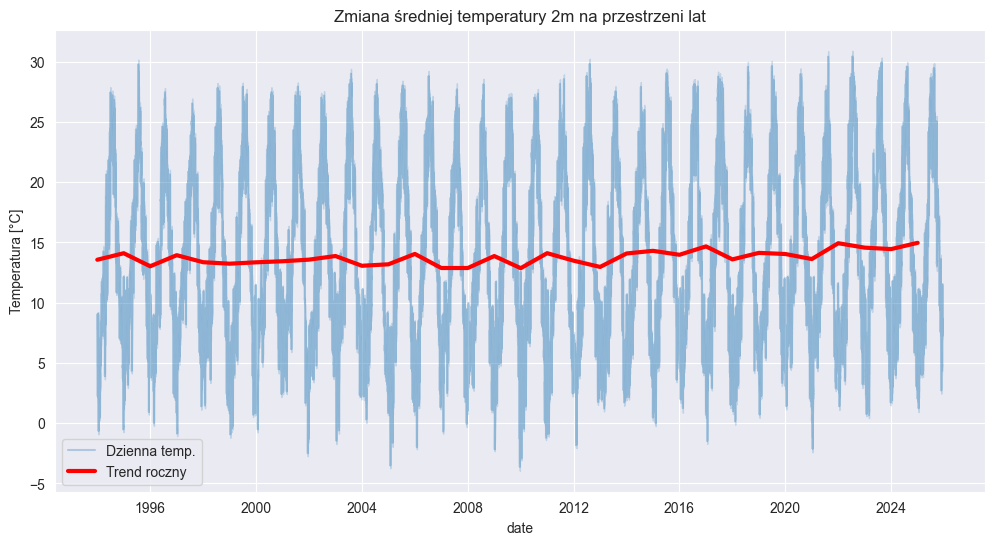

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='t2m_mean', alpha=0.3, label='Dzienna temp.')
sns.lineplot(data=df_yearly, x=pd.to_datetime(df_yearly['year'], format='%Y'), y='t2m_mean', color='red', linewidth=3, label='Trend roczny')
plt.title('Zmiana średniej temperatury 2m na przestrzeni lat')
plt.ylabel('Temperatura [°C]')
plt.show()

C:\Users\oliwi\AppData\Local\Temp\ipykernel_8940\2166718141.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\oliwi\PycharmProjects\Long_Term_Climate_Analysis_Madrid_ERA5\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


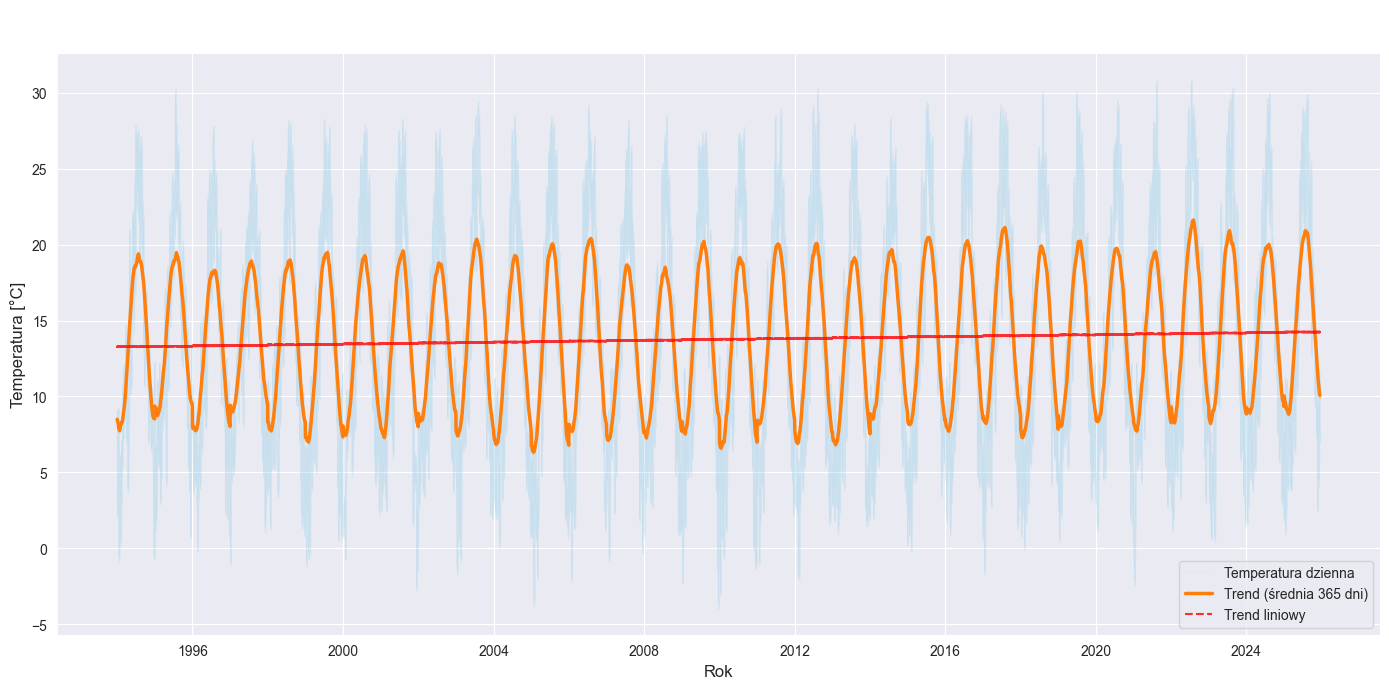

In [31]:
df['t2m_roll_365'] = df['t2m_mean'].rolling(window=365, center=True, min_periods=1).mean()

plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='date', y='t2m_mean', color='skyblue', alpha=0.15, linewidth=0.5, label='Temperatura dzienna')

sns.lineplot(data=df, x='date', y='t2m_roll_365', color='#ff7f0e', linewidth=2.5, label='Trend (średnia 365 dni)')

x_numeric = np.arange(len(df))
z = np.polyfit(x_numeric, df['t2m_mean'], 1)
p = np.poly1d(z)
plt.plot(df['date'], p(x_numeric), "r--", alpha=0.8, linewidth=1.5, label='Trend liniowy')

plt.title('Długookresowa zmiana temperatury w centralnej Hiszpanii (1994-2025)', fontsize=16, pad=20, color='white')
plt.ylabel('Temperatura [°C]', fontsize=12)
plt.xlabel('Rok', fontsize=12)
plt.grid(True)

plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [34]:


df_map = df.groupby(['year', 'latitude', 'longitude'])['t2m_mean'].mean().reset_index()

fig = px.scatter_map(
    df_map,
    lat="latitude",
    lon="longitude",
    color="t2m_mean",
    animation_frame="year",
    zoom=5,
    map_style="carto-positron",
    title="Średnia temperatura roczna w punktach siatki"
)

fig.show()
print(df_map.head())

   year  latitude  longitude   t2m_mean
0  1994      38.5      -6.00  16.011028
1  1994      38.5      -5.75  15.985209
2  1994      38.5      -5.50  15.965748
3  1994      38.5      -5.25  16.206177
4  1994      38.5      -5.00  16.011879


In [35]:
regional_daily = df.groupby('date', as_index=False).mean()

regional_daily.head(5) ## Srednia z wszystkich punktow na jeden dzień
regional_daily.info()
regional_daily['date'] = pd.to_datetime(regional_daily['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11670 entries, 0 to 11669
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           11670 non-null  object 
 1   latitude       11670 non-null  float64
 2   longitude      11670 non-null  float64
 3   t2m_mean       11670 non-null  float32
 4   t2m_max        11670 non-null  float32
 5   t2m_min        11670 non-null  float32
 6   d2m_mean       11670 non-null  float32
 7   skt_mean       11670 non-null  float32
 8   sp_mean        11670 non-null  float32
 9   blh_mean       11670 non-null  float32
 10  tcc_mean       11670 non-null  float32
 11  soil_moisture  11670 non-null  float32
 12  tp_sum         11670 non-null  float32
 13  e_sum          11670 non-null  float32
 14  ssrd_sum       11670 non-null  float32
 15  hour           11670 non-null  float64
 16  year           11670 non-null  float64
 17  month          11670 non-null  float64
 18  day   

# Przygotowanie danych rocznych

In [36]:
month_mean  = (df.groupby('month')['t2m_mean'].mean())
day_mean    = (df.groupby('day')['t2m_mean'].mean())
year_mean   = (df.groupby('year')['t2m_mean'].mean())
season_mean = (df.groupby('season')['t2m_mean'].mean())

month_min   = (df.groupby('month')['t2m_min'].mean())
day_min     = (df.groupby('day')['t2m_min'].mean())
year_min    = (df.groupby('year')['t2m_min'].mean())
season_min  = (df.groupby('season')['t2m_min'].mean())

month_max   = (df.groupby('month')['t2m_max'].mean())
day_max     = (df.groupby('day')['t2m_max'].mean())
year_max    = (df.groupby('year')['t2m_max'].mean())
season_max  = (df.groupby('season')['t2m_max'].mean())


In [37]:
day_mean = (
    df.groupby('day')['t2m_mean'].mean()
)
day_mean

day
1     13.738859
2     13.713614
3     13.681037
4     13.694385
5     13.635606
6     13.640924
7     13.568752
8     13.598463
9     13.691336
10    13.741780
11    13.821876
12    13.825897
13    13.716056
14    13.646510
15    13.512870
16    13.579144
17    13.646867
18    13.701020
19    13.705306
20    13.772704
21    13.811588
22    13.776409
23    13.834435
24    13.826381
25    13.768083
26    13.652704
27    13.682706
28    13.728535
29    14.306239
30    14.500204
31    14.258425
Name: t2m_mean, dtype: float32

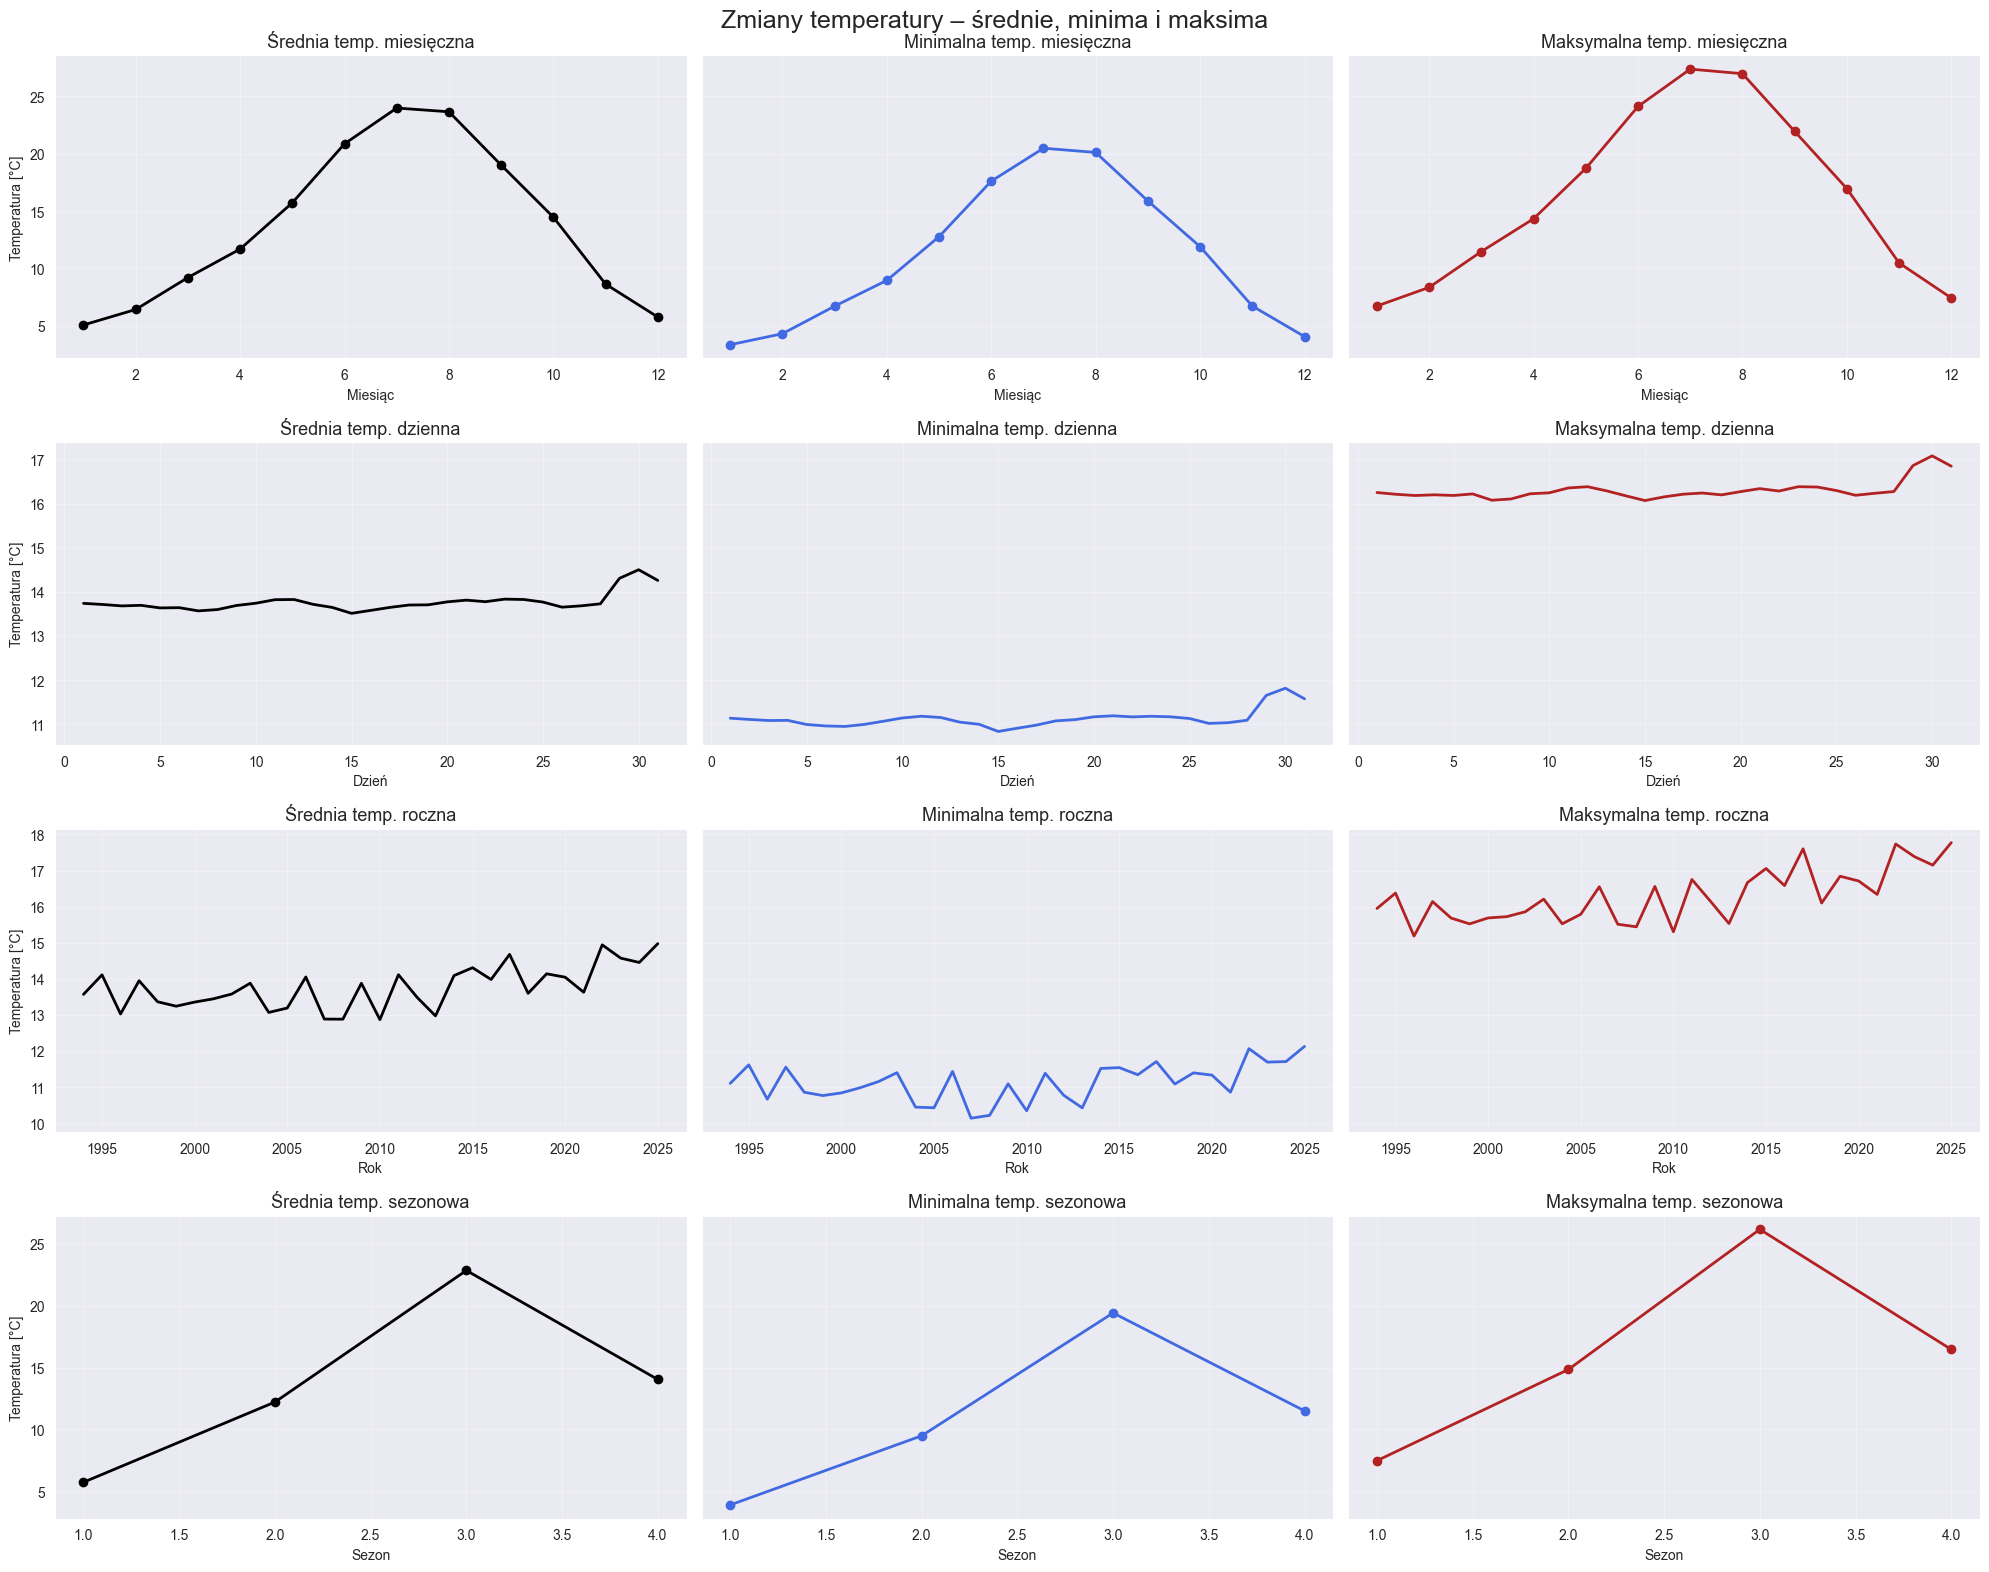

In [38]:

plot_data = [
    (month_mean, "Średnia temp. miesięczna"),
    (month_min, "Minimalna temp. miesięczna"),
    (month_max, "Maksymalna temp. miesięczna"),

    (day_mean, "Średnia temp. dzienna"),
    (day_min, "Minimalna temp. dzienna"),
    (day_max, "Maksymalna temp. dzienna"),

    (year_mean, "Średnia temp. roczna"),
    (year_min, "Minimalna temp. roczna"),
    (year_max, "Maksymalna temp. roczna"),

    (season_mean, "Średnia temp. sezonowa"),
    (season_min, "Minimalna temp. sezonowa"),
    (season_max, "Maksymalna temp. sezonowa"),
]

fig, axes = plt.subplots(4, 3, figsize=(20, 16), sharey='row')

colors = {
    'mean': 'black',
    'min': 'royalblue',
    'max': 'firebrick'
}

for idx, (data, title) in enumerate(plot_data):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    marker = 'o' if len(data) <= 12 else None

    data.plot(
        ax=ax,
        linewidth=2,
        marker=marker,
        color=colors[['mean','min','max'][col]]
    )

    ax.set_title(title, fontsize=13)
    ax.grid(True, alpha=0.3)

    if row == 0:
        ax.set_xlabel("Miesiąc")
    elif row == 1:
        ax.set_xlabel("Dzień")
    elif row == 2:
        ax.set_xlabel("Rok")
    else:
        ax.set_xlabel("Sezon")

    if col == 0:
        ax.set_ylabel("Temperatura [°C]")

plt.suptitle("Zmiany temperatury – średnie, minima i maksima", fontsize=18)
plt.tight_layout()
plt.show()


# Najcieplejsze dni w roku oraz najzimniejsze 

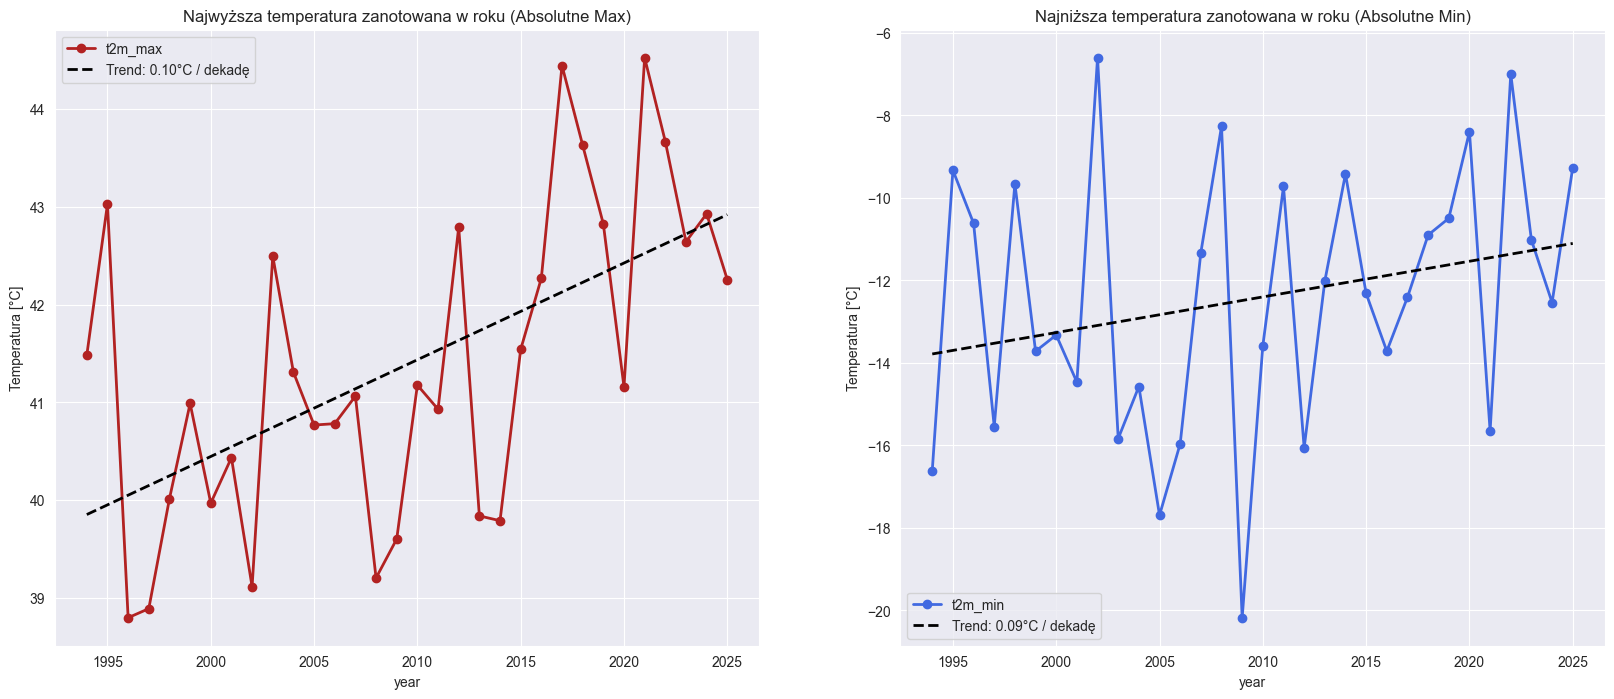

In [40]:
hottest_day = df.groupby('year')["t2m_max"].max()
coldest_day = df.groupby('year')["t2m_min"].min()

z_hot = np.polyfit(hottest_day.index, hottest_day.values, 1)
p_hot = np.poly1d(z_hot)

z_cold = np.polyfit(coldest_day.index, coldest_day.values, 1)
p_cold = np.poly1d(z_cold)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

hottest_day.plot(
    kind="line", ax=axes[0],
    title="Najwyższa temperatura zanotowana w roku (Absolutne Max)",
    color="firebrick", marker='o', linewidth=2
)
axes[0].set_ylabel("Temperatura [°C]")
axes[0].plot(
    hottest_day.index,
    p_hot(hottest_day.index),
    'k--',
    linewidth=2,
    label=f"Trend: {z_hot[0]:.2f}°C / dekadę"
)
axes[0].legend()

coldest_day.plot(
    kind="line", ax=axes[1],
    title="Najniższa temperatura zanotowana w roku (Absolutne Min)",
    color="royalblue", marker='o', linewidth=2
)
axes[1].set_ylabel("Temperatura [°C]")
axes[1].plot(
    coldest_day.index,
    p_cold(coldest_day.index),
    'k--',
    linewidth=2,
    label=f"Trend: {z_cold[0]:.2f}°C / dekadę"
)
axes[1].legend()
plt.show()

# Liczba upalnych dni / mroźnych w roku patrzac na kazda ilosc stacji

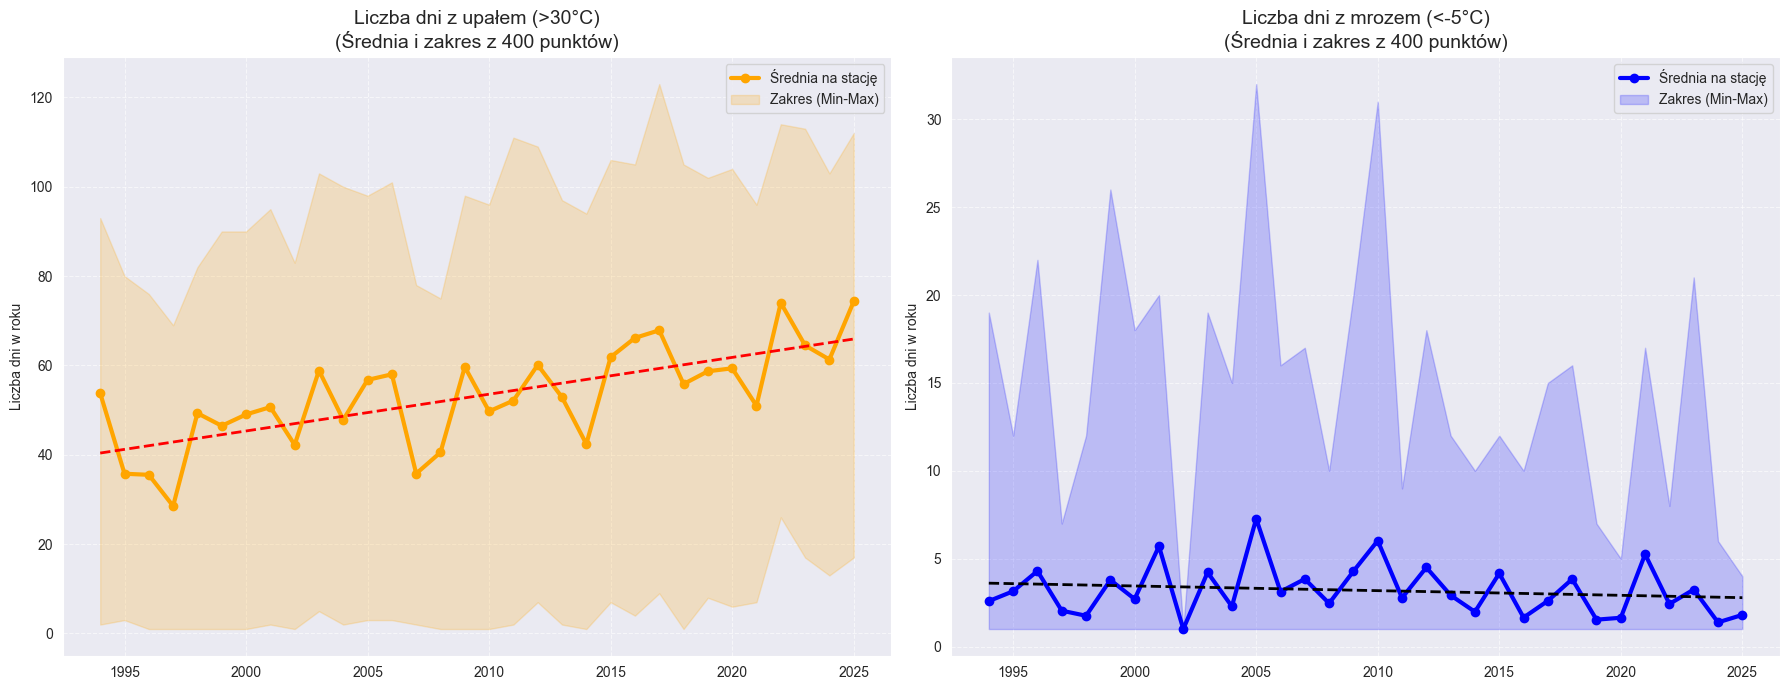

In [41]:
hot_stats = df[df['t2m_max'] > 30].groupby(['year', 'latitude', 'longitude'])['date'].nunique().reset_index()
hot_yearly = hot_stats.groupby('year')['date'].agg(['mean', 'max', 'min'])

cold_stats = df[df['t2m_min'] < -5].groupby(['year', 'latitude', 'longitude'])['date'].nunique().reset_index()
cold_yearly = cold_stats.groupby('year')['date'].agg(['mean', 'max', 'min'])

z_hot = np.polyfit(hot_yearly.index, hot_yearly['mean'], 1)
p_hot = np.poly1d(z_hot)

z_cold = np.polyfit(cold_yearly.index, cold_yearly['mean'], 1)
p_cold = np.poly1d(z_cold)

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

axes[0].plot(hot_yearly.index, hot_yearly['mean'], color='orange', marker='o', linewidth=3, label='Średnia na stację')
axes[0].fill_between(hot_yearly.index, hot_yearly['min'], hot_yearly['max'], color='orange', alpha=0.2, label='Zakres (Min-Max)')
axes[0].set_title("Liczba dni z upałem (>30°C)\n(Średnia i zakres z 400 punktów)", fontsize=14)
axes[0].set_ylabel("Liczba dni w roku")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[0].plot(
    hot_yearly.index,
    p_hot(hot_yearly.index),
    'r--',
    linewidth=2,
    label=f"Trend: {z_hot[0]*10:.1f} dni / dekadę"
)

axes[1].plot(cold_yearly.index, cold_yearly['mean'], color='blue', marker='o', linewidth=3, label='Średnia na stację')
axes[1].fill_between(cold_yearly.index, cold_yearly['min'], cold_yearly['max'], color='blue', alpha=0.2, label='Zakres (Min-Max)')
axes[1].set_title("Liczba dni z mrozem (<-5°C)\n(Średnia i zakres z 400 punktów)", fontsize=14)
axes[1].set_ylabel("Liczba dni w roku")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(
    cold_yearly.index,
    p_cold(cold_yearly.index),
    'k--',
    linewidth=2,
    label=f"Trend: {z_cold[0]*10:.1f} dni / dekadę"
)

plt.tight_layout()
plt.show()

# Wykres anomali Temperatury

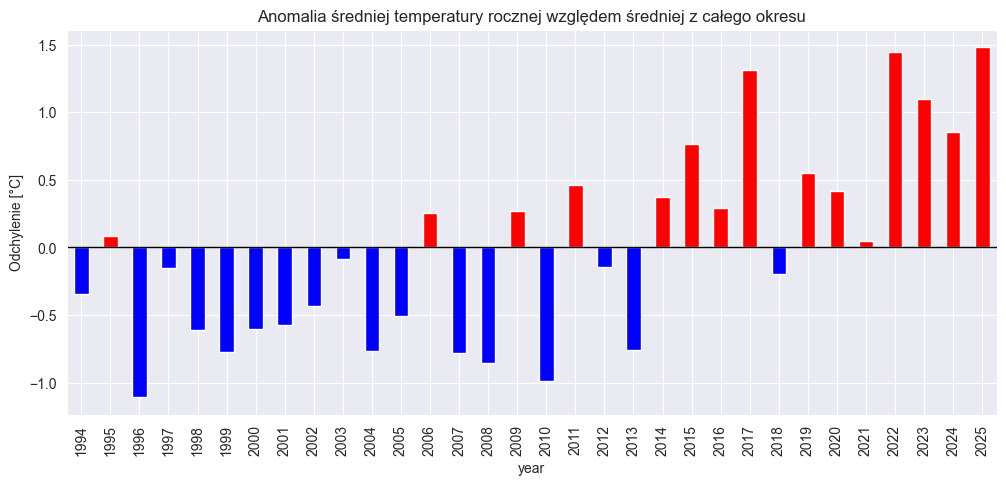

In [42]:
yearly_temp = df.groupby('year')['t2m_max'].mean()

baseline = yearly_temp.mean()
anomalies = yearly_temp - baseline

plt.figure(figsize=(12, 5))
colors = ['red' if x > 0 else 'blue' for x in anomalies]
anomalies.plot(kind='bar', color=colors)
plt.axhline(0, color='black', linewidth=1)
plt.title("Anomalia średniej temperatury rocznej względem średniej z całego okresu")
plt.ylabel("Odchylenie [°C]")
plt.show()



# Przesunięcie Rozkładu 

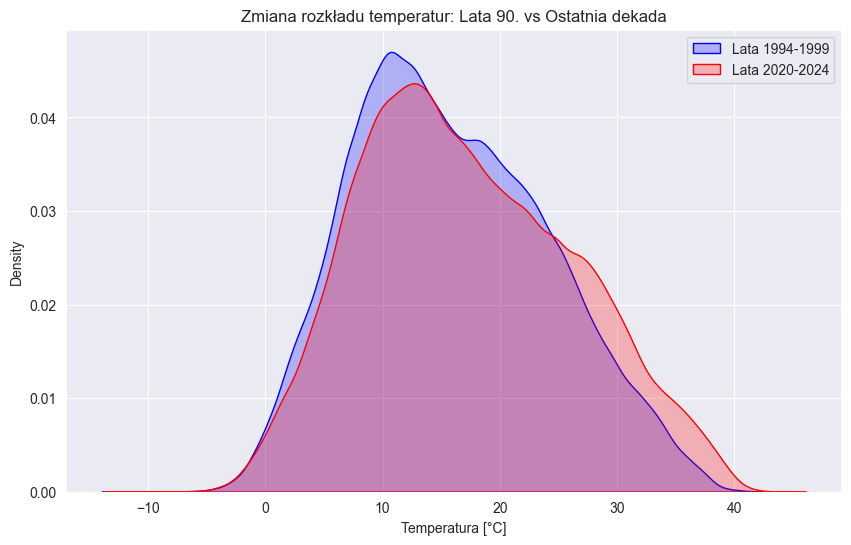

In [43]:
early_period = df[df['year'] < 2000]['t2m_max']
late_period = df[df['year'] > 2019]['t2m_max']

plt.figure(figsize=(10, 6))
sns.kdeplot(early_period, fill=True, label='Lata 1994-1999', color='blue')
sns.kdeplot(late_period, fill=True, label='Lata 2020-2024', color='red')
plt.title("Zmiana rozkładu temperatur: Lata 90. vs Ostatnia dekada")
plt.xlabel("Temperatura [°C]")
plt.legend()
plt.show()

# Warming Stripes

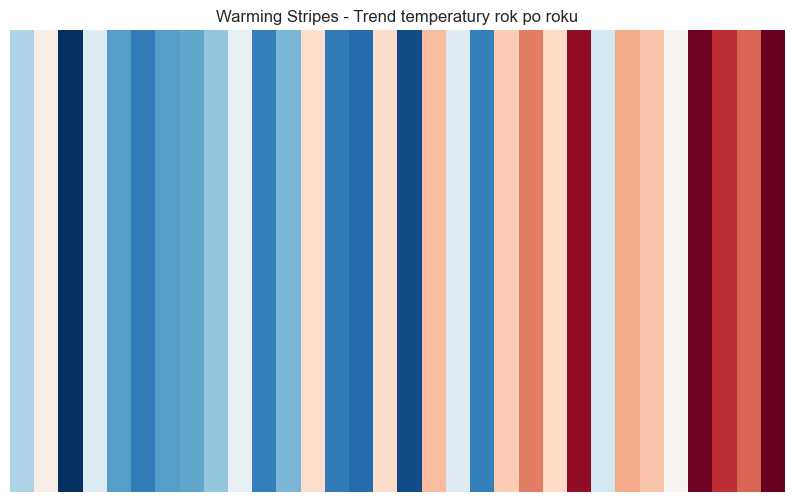

In [44]:
data = df.groupby('year')['t2m_max'].mean().values.reshape(1, -1)

plt.figure( figsize=(10, 6) )
plt.imshow(data, cmap='RdBu_r', aspect='auto',
           norm=mcolors.TwoSlopeNorm(vmin=data.min(), vcenter=data.mean(), vmax=data.max()))
plt.axis('off')
plt.title("Warming Stripes - Trend temperatury rok po roku")
plt.show()


# Warming Stripes - Trend temperatury rok po roku

Na tym wykresie każda pionowa kreska reprezentuje jeden rok.
Kolor wskazuje średnią roczną temperaturę maksymalną:
- Ciemnoniebieski: chłodniejsze lata
- Jasnoróżowy/czerwony: cieplejsze lata

Brak osi i konkretnych wartości liczbowych pozwala łatwo zobaczyć trend ocieplenia w czasie:
im więcej czerwieni po prawej stronie, tym silniejszy wzrost temperatury w ostatnich latach.

Możemy zobaczyć, że zauważalny jest zwrost temperatury

# Długość Fal Upałów ( dni powyżej 30 stopni pod rząd )


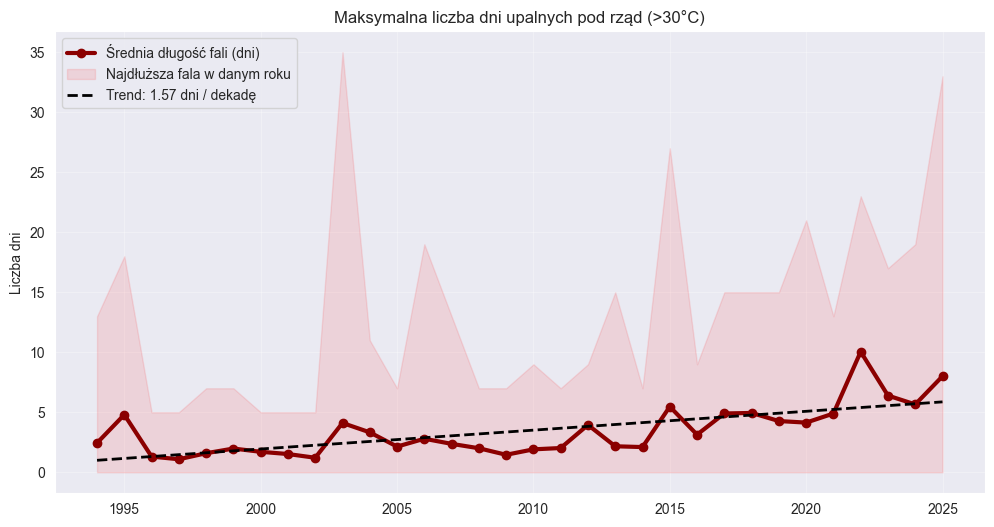

In [45]:
df = df.sort_values(['latitude', 'longitude', 'date'])

df['is_hot'] = df['t2m_max'] > 30
groups = (df['is_hot'] != df.groupby(['latitude', 'longitude'])['is_hot'].shift()).cumsum()

df['streak'] = df.groupby(['latitude', 'longitude', groups])['is_hot'].transform('sum')

heatwave_max = df[df['is_hot']].groupby(['year', 'latitude', 'longitude'])['streak'].max().reset_index()

heatwave_avg = heatwave_max.groupby('year')['streak'].mean()
heatwave_record = heatwave_max.groupby('year')['streak'].max()

z_hw = np.polyfit(heatwave_avg.index, heatwave_avg.values, 1)
p_hw = np.poly1d(z_hw)

plt.figure(figsize=(12, 6))
plt.plot(heatwave_avg.index, heatwave_avg, marker='o', color='darkred', linewidth=3, label='Średnia długość fali (dni)')
plt.fill_between(heatwave_avg.index, 0, heatwave_record, color='red', alpha=0.1, label='Najdłuższa fala w danym roku')
plt.title("Maksymalna liczba dni upalnych pod rząd (>30°C)")
plt.ylabel("Liczba dni")
plt.plot(
    heatwave_avg.index,
    p_hw(heatwave_avg.index),
    'k--',
    linewidth=2,
    label=f"Trend: {z_hw[0]*10:.2f} dni / dekadę"
)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Szereg czasowy temperatury z linia trendu


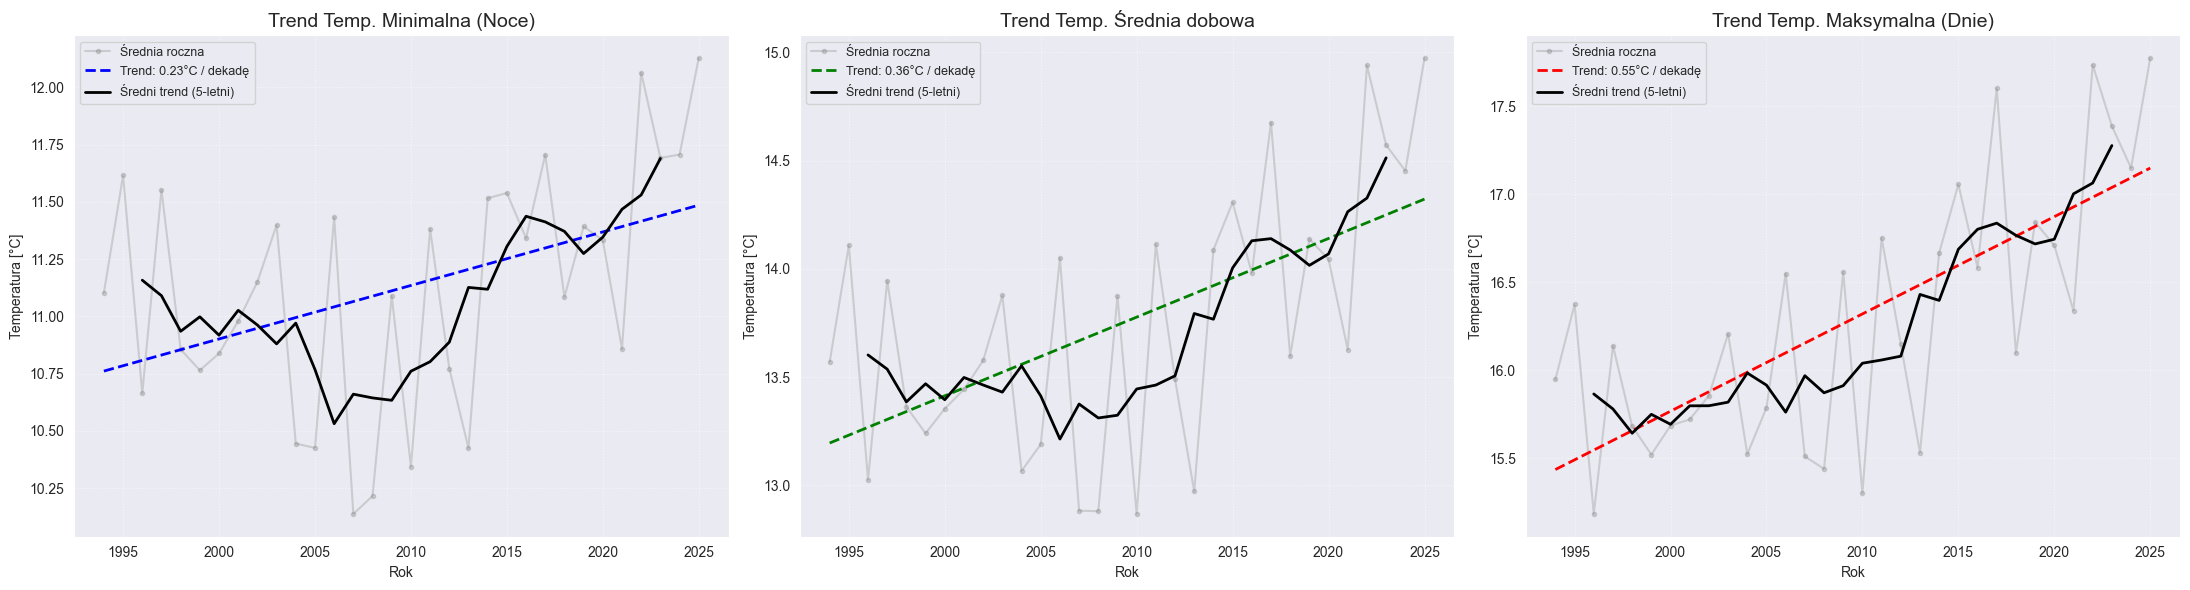

Szybkość ocieplenia Minimalna (Noce): 0.23°C na dekadę
Szybkość ocieplenia Średnia dobowa: 0.36°C na dekadę
Szybkość ocieplenia Maksymalna (Dnie): 0.55°C na dekadę


In [46]:
yearly_data = df.groupby('year')[['t2m_min', 't2m_mean', 't2m_max']].mean()

params = [
    ('t2m_min', 'Minimalna (Noce)', 'blue'),
    ('t2m_mean', 'Średnia dobowa', 'green'),
    ('t2m_max', 'Maksymalna (Dnie)', 'red')
]

fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharex=True)

for i, (col, label, color) in enumerate(params):
    y = yearly_data[col]
    x = yearly_data.index

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    trend_per_decade = z[0] * 10

    axes[i].plot(x, y, marker='.', color='gray', alpha=0.3, label='Średnia roczna')

    axes[i].plot(x, p(x), color=color, linestyle='--', linewidth=2,
                 label=f'Trend: {trend_per_decade:.2f}°C / dekadę')

    axes[i].plot(x, y.rolling(window=5, center=True).mean(),
                 color='black', linewidth=2, label='Średni trend (5-letni)')

    axes[i].set_title(f"Trend Temp. {label}", fontsize=14)
    axes[i].set_ylabel("Temperatura [°C]")
    axes[i].set_xlabel("Rok")
    axes[i].legend(loc='upper left', fontsize=9)
    axes[i].grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

for col, label, _ in params:
    z = np.polyfit(yearly_data.index, yearly_data[col], 1)
    print(f"Szybkość ocieplenia {label}: {z[0]*10:.2f}°C na dekadę")

# Analiza trendów ekstremalnych ( TMIN, TMAX ) temperatur w rozbiciu na pory roku

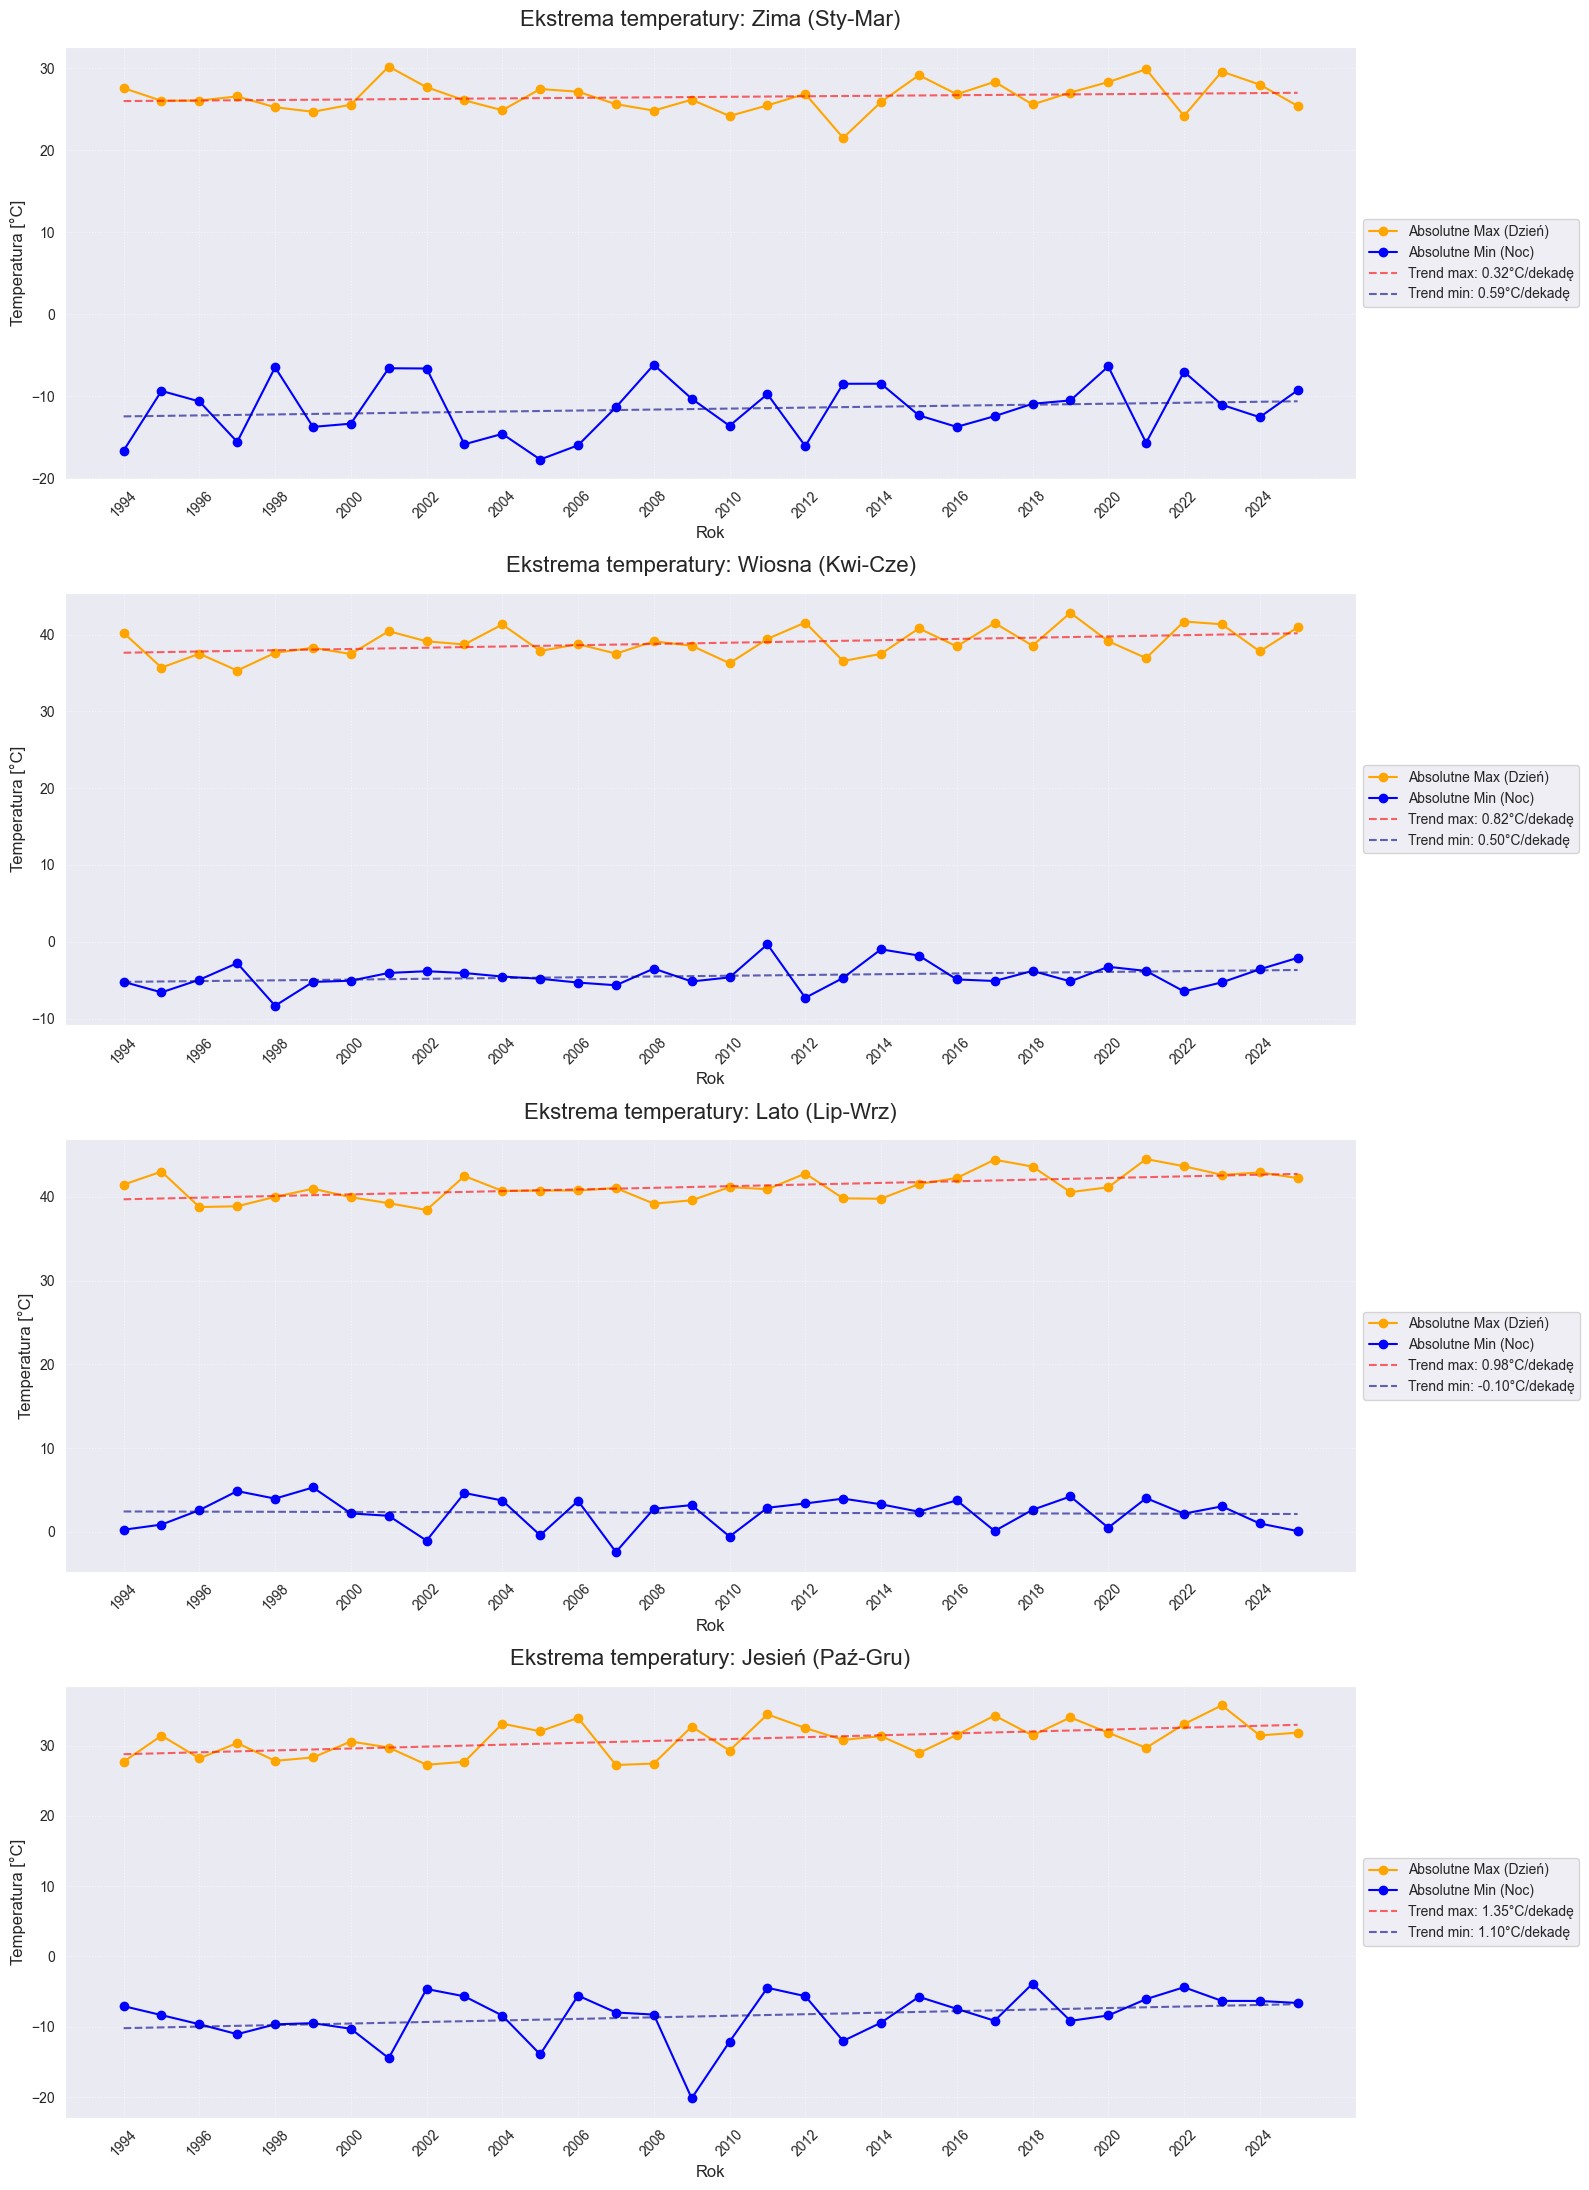

In [47]:
df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].dt.quarter

quarterly_extrema = df.groupby(['year', 'season']).agg({
    't2m_min': 'min',
    't2m_max': 'max'
}).reset_index()

q_labels = {1: 'Zima (Sty-Mar)', 2: 'Wiosna (Kwi-Cze)', 3: 'Lato (Lip-Wrz)', 4: 'Jesień (Paź-Gru)'}


fig, axes = plt.subplots(4, 1, figsize=(16, 22))

for q in [1, 2, 3, 4]:
    data_q = quarterly_extrema[quarterly_extrema['season'] == q]
    ax = axes[q-1]

    ax.plot(data_q['year'], data_q['t2m_max'], marker='o', color='orange', label='Absolutne Max (Dzień)')
    ax.plot(data_q['year'], data_q['t2m_min'], marker='o', color='blue', label='Absolutne Min (Noc)')


    for col, color in [('t2m_max', 'red'), ('t2m_min', 'darkblue')]:
        z = np.polyfit(data_q['year'], data_q[col], 1)
        p = np.poly1d(z)
        ax.plot(data_q['year'], p(data_q['year']), color=color, linestyle='--', alpha=0.6,
                label=f'Trend {col[-3:]}: {z[0]*10:.2f}°C/dekadę')

    ax.set_title(f"Ekstrema temperatury: {q_labels[q]}", fontsize=16, pad=15)
    ax.set_ylabel("Temperatura [°C]", fontsize=12)
    ax.set_xlabel("Rok", fontsize=12)


    years = data_q['year'].unique()
    ax.set_xticks(years[::2])
    ax.tick_params(axis='x', rotation=45)

    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

plt.tight_layout()
plt.show()

# szeregu czasowego dla całego obszaru

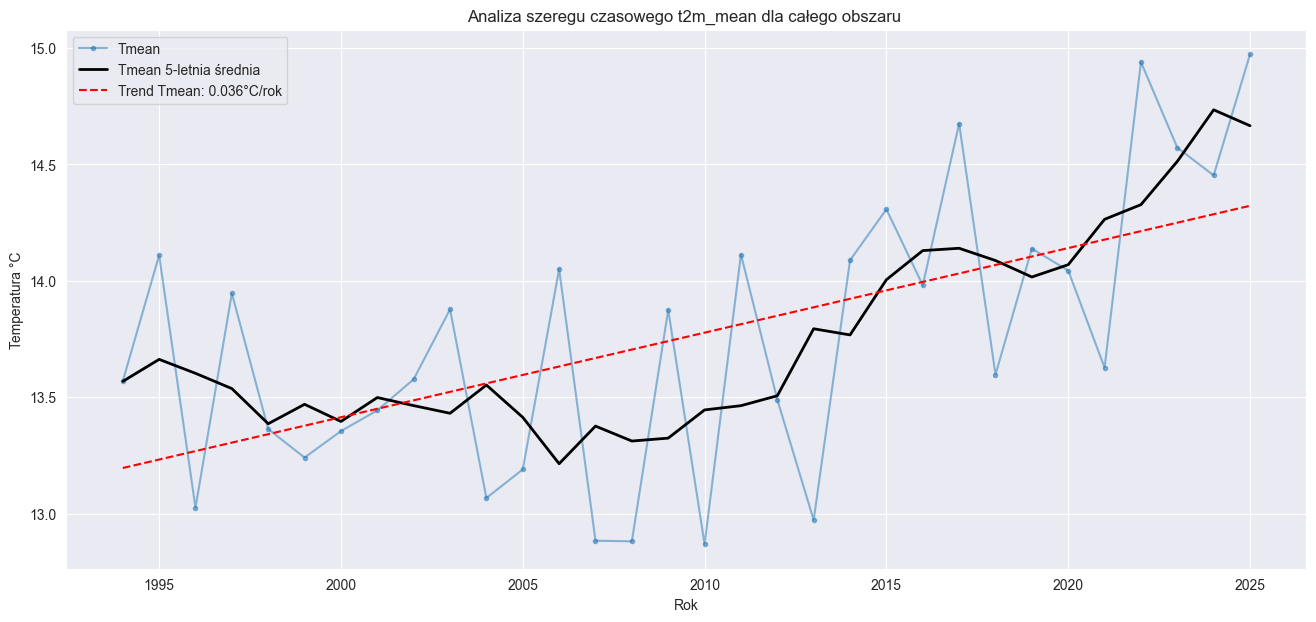

In [48]:
yearly_data_smooth = yearly_data.rolling(window=5, center=True, min_periods=1).mean()
z_mean = np.polyfit( yearly_data.index, yearly_data['t2m_mean'], 1)
p_mean = np.poly1d(z_mean)

plt.figure(figsize=(16, 7))
plt.plot( yearly_data.index, yearly_data['t2m_mean'], marker ='.', alpha = 0.5, label = "Tmean")
plt.plot(yearly_data_smooth.index, yearly_data_smooth['t2m_mean'], label = "Tmean 5-letnia średnia", color = "black",linewidth = 2)
plt.plot( yearly_data.index, p_mean(yearly_data.index), 'r--',label=f'Trend Tmean: {z_mean[0]:.3f}°C/rok')
plt.legend()
plt.xlabel("Rok")
plt.ylabel("Temperatura °C")
plt.title("Analiza szeregu czasowego t2m_mean dla całego obszaru ")
plt.show()



In [49]:

summary_stats = df.groupby('year').agg({
    't2m_mean': 'mean',
    't2m_max': 'max',
    't2m_min': 'min'
}).describe()

print("Podsumowanie statystyczne wieloletnie:")
print(summary_stats)

Podsumowanie statystyczne wieloletnie:
        t2m_mean    t2m_max    t2m_min
count  32.000000  32.000000  32.000000
mean   13.759201  41.386818 -12.444075
std     0.598239   1.607877   3.263731
min    12.868575  38.796295 -20.177246
25%    13.326108  40.002594 -14.815704
50%    13.751044  41.167999 -12.364105
75%    14.110496  42.681366  -9.705963
max    14.973378  44.527496  -6.602631


# Susza i Bilans Wodny (tp_sum, e_sum, soil_moisture)

tp_sum	Suma całkowitego opadu (deszcz + śnieg).	Suma (12h)
e_sum	Suma ewaporacji (odparowywania wody).	Wartości ujemne = utrata wody
soil_moisture	Wilgotność gleby w warstwie powierzchniowej (0-7cm).


In [50]:
yearly_water = df.groupby('year').mean().reset_index()

yearly_water['P_minus_E'] = yearly_water['tp_sum'] - yearly_water['e_sum']

# Trend Bilansu Wodnego

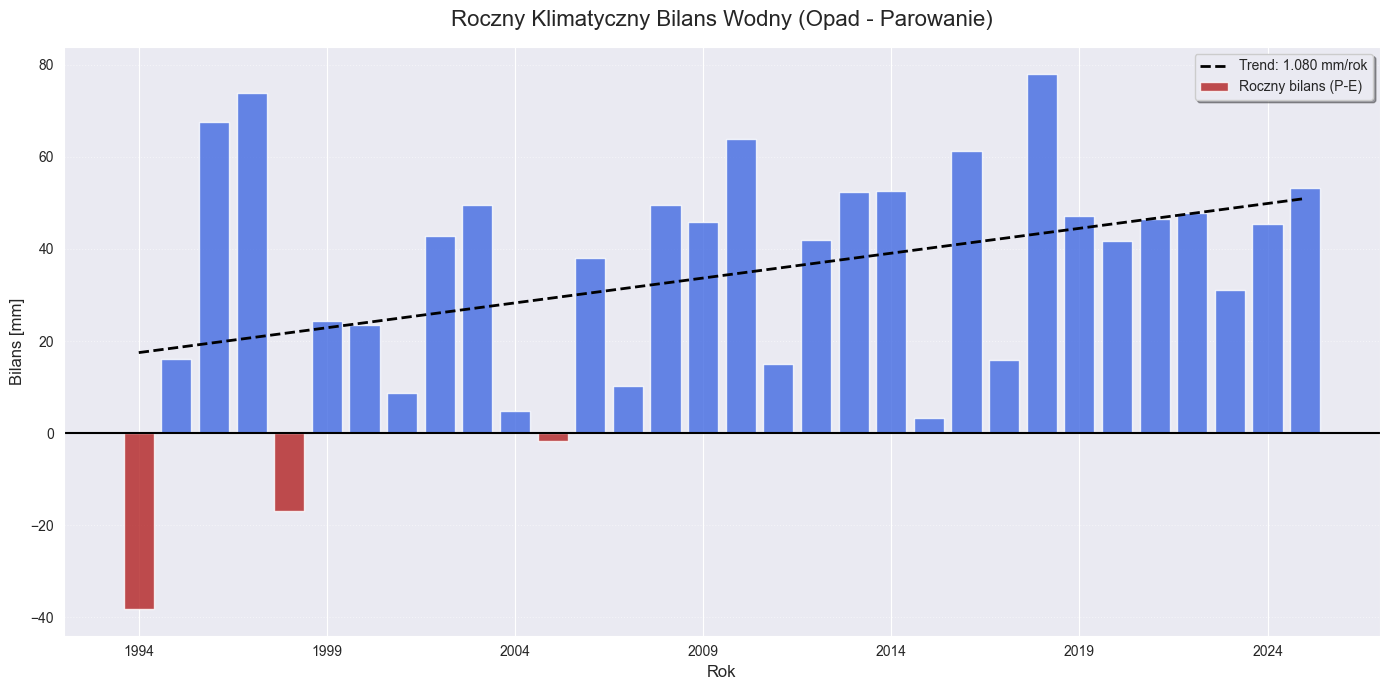

Średni roczny bilans: 34.22 mm
Roczna zmiana wg trendu: 1.080 mm/rok


In [19]:
yearly_sums = df.groupby(['year', 'latitude', 'longitude']).agg({
    'tp_sum': 'sum',
    'e_sum': 'sum'
}).reset_index()

yearly_sums['P_minus_E'] = yearly_sums['tp_sum'] + yearly_sums['e_sum']

final_yearly = yearly_sums.groupby('year')['P_minus_E'].mean().reset_index()

plt.figure(figsize=(14, 7))

colors = ['royalblue' if x > 0 else 'firebrick' for x in final_yearly['P_minus_E']]

plt.bar(final_yearly['year'], final_yearly['P_minus_E'], color=colors, alpha=0.8, label='Roczny bilans (P-E)')


z = np.polyfit(final_yearly['year'], final_yearly['P_minus_E'], 1)
p = np.poly1d(z)
plt.plot(final_yearly['year'], p(final_yearly['year']), "k--", linewidth=2,
         label=f"Trend: {z[0]:.3f} mm/rok")


plt.axhline(0, color='black', linewidth=1.5)
plt.title("Roczny Klimatyczny Bilans Wodny (Opad - Parowanie)", fontsize=16, pad=15)
plt.ylabel("Bilans [mm]", fontsize=12)
plt.xlabel("Rok", fontsize=12)

plt.xticks(np.arange(final_yearly['year'].min(), final_yearly['year'].max() + 1, 5))

plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend(frameon=True, shadow=True)

plt.tight_layout()
plt.show()

print(f"Średni roczny bilans: {final_yearly['P_minus_E'].mean():.2f} mm")
print(f"Roczna zmiana wg trendu: {z[0]:.3f} mm/rok")

### 1. Średnio jest "wilgotniej", ale nie co roku
Linia trendu (ta przerywana) pnie się w górę, co sugeruje, że z dekady na dekadę w regionie zostaje średnio więcej wody.
*   **W roku 1994** linia trendu była na poziomie ok. **20 mm**.
*   **W roku 2024** linia trendu jest na poziomie ok. **50 mm**.
To oznacza wzrost o około 30 mm w ciągu 30 lat.

### 2. Dlaczego tak się dzieje? (P - E)
Bilans to różnica: **Opad (P) minus Parowanie (E)**. Jeśli bilans rośnie, mogą zachodzić dwa scenariusze:
*   **Opad rośnie szybciej niż parowanie:** Nawet jeśli robi się cieplej (przez co parowanie rośnie), to opady zwiększają się na tyle mocno, że "nadrabiają" te straty z nawiązką.
*   **Opad jest stabilny, a parowanie maleje:** (Mało prawdopodobne przy globalnym ociepleniu).

### 3. Czy to oznacza koniec susz?
**Absolutnie nie.** Popatrz na słupki:
*   Mimo rosnącego trendu, nadal zdarzają się lata z **ujemnym bilansem** (czerwone słupki, np. rok 2005).
*   Trend mówi nam o **średnim stanie klimatu**, ale **ekstremy** (bardzo suche lata) nadal mogą występować. Często w ocieplającym się klimacie mamy do czynienia z sytuacją, gdzie rzadziej pada, ale jak już spadnie deszcz, to jest on ekstremalnie silny (ulewy), co podbija statystykę roczną, mimo że przez większość roku jest sucho.

### 4. Kontekst Twoich poprzednich wykresów (Temperatura)
Wcześniej analizowałeś temperaturę i tam trend był wyraźnie wzrostowy (ocieplenie).
*   Zazwyczaj ocieplenie powoduje wysychanie (większe parowanie).
*   U Ciebie jednak bilans wodny rośnie. To sugeruje, że Twój region (prawdopodobnie jakaś część Hiszpanii lub Europy Środkowej, zależnie od danych) otrzymuje w ostatnich latach **wyraźnie więcej opadów**, co kompensuje skutki wzrostu temperatury.

### Podsumowując:
Wykres mówi: **"Statystycznie w tym regionie przybywa wody netto w skali roku"**.

# Stres wodny ( Tmax vs Soil Moisture )

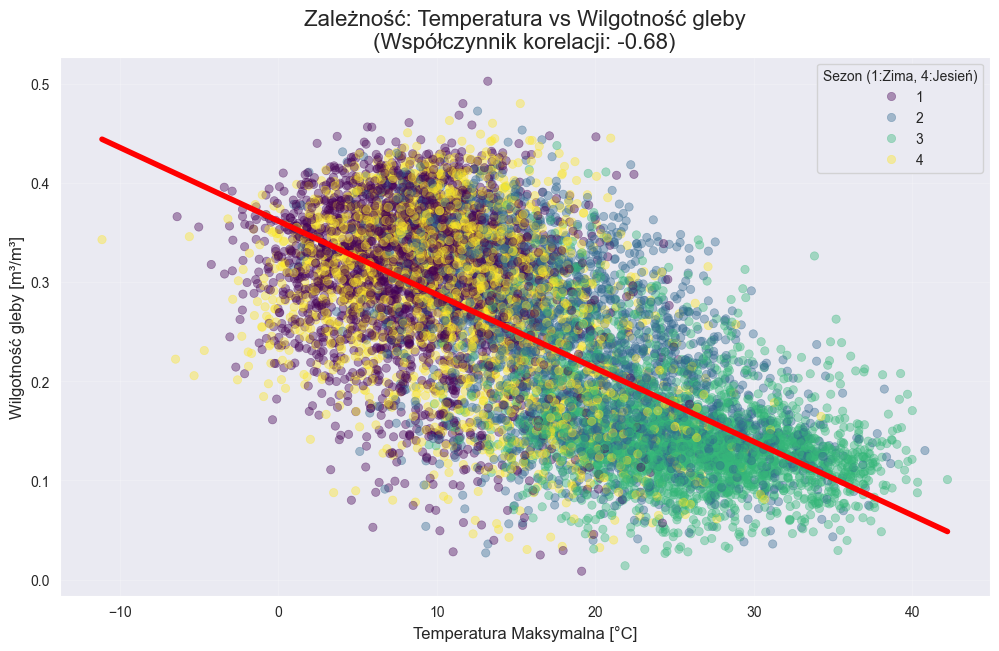

In [51]:
df_sample = df.sample(n=min(10000, len(df)))

corr = df_sample['t2m_max'].corr(df_sample['soil_moisture'])

plt.figure(figsize=(12, 7))


sns.scatterplot(data=df_sample, x='t2m_max', y='soil_moisture',
                hue='season', palette='viridis', alpha=0.4, edgecolor=None)

sns.regplot(data=df_sample, x='t2m_max', y='soil_moisture',
            scatter=False, color='red', ci=None,
            line_kws={'linewidth': 4, 'label': f'Trend (Korelacja: {corr:.2f})'})

plt.title(f"Zależność: Temperatura vs Wilgotność gleby\n(Współczynnik korelacji: {corr:.2f})", fontsize=16)
plt.xlabel("Temperatura Maksymalna [°C]", fontsize=12)
plt.ylabel("Wilgotność gleby [m³/m³]", fontsize=12)
plt.legend(title="Sezon (1:Zima, 4:Jesień)", loc='upper right')
plt.grid(True, alpha=0.2)

plt.show()

**Analiza Stresu Wodnego i Wysychania Gleby**

Wykres punktowy (scatterplot) przedstawia relację między temperaturą maksymalną a wilgotnością powierzchniowej warstwy gleby.

**Kluczowe obserwacje:**
 1. **Ujemna korelacja:** Współczynnik korelacji (blisko -0.6) potwierdza, że wzrost temperatury jest głównym czynnikiem redukującym zasoby wodne w glebie.
 2. **Bariera termiczna:** Powyżej temperatury 30°C wilgotność gleby niemal zawsze spada poniżej 0.15 m³/m³, co wskazuje na stan permanentnego stresu wodnego dla roślinności w okresach letnich.
 3. **Różnice sezonowe:** Sezon letni (żółte punkty na nowej palecie) skupia się wyłącznie w prawym dolnym rogu, co pokazuje, że wysokie temperatury w Madrycie uniemożliwiają utrzymanie wilgoci w glebie, nawet jeśli wystąpią opady.

 **Wniosek:** Rosnący trend temperatury (widoczny na poprzednich wykresach) bezpośrednio przekłada się na coraz częstsze okresy niskiej wilgotności gleby, co zagraża ekosystemom i rolnictwu.


# Przesunięcie rozkładu wilgotności gleby ( KDE )

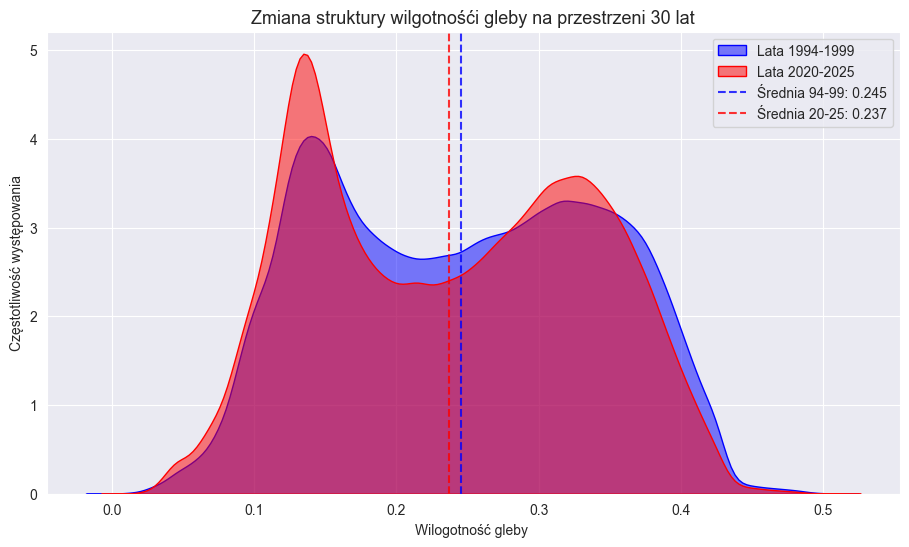

In [52]:
plt.figure( figsize = ( 11,6 ) )

easly_sm = df[ df["year"] < 2000 ]['soil_moisture']
late_sm = df[df["year"] > 2019 ]['soil_moisture']

mean_early = easly_sm.mean()
mean_late = late_sm.mean()

sns.kdeplot( easly_sm, fill = True, label = "Lata 1994-1999", color = "blue", alpha = 0.5)
sns.kdeplot( late_sm,  fill = True, label = "Lata 2020-2025", color = "red", alpha = 0.5)

plt.axvline(mean_early, color='blue', linestyle='--', alpha=0.8, label=f'Średnia 94-99: {mean_early:.3f}')
plt.axvline(mean_late, color='red', linestyle='--', alpha=0.8, label=f'Średnia 20-25: {mean_late:.3f}')


plt.title("Zmiana struktury wilgotnośći gleby na przestrzeni 30 lat", fontsize = 13)
plt.xlabel("Wilogotność gleby ")
plt.ylabel("Częstotliwość występowania")
plt.legend()
plt.show()

### 1. Średnia to tylko wierzchołek góry lodowej
*   **Wysoki czerwony szczyt po lewej:** To jest "częstość", o której piszesz. Widzisz, że czerwona góra w okolicach **0.13** jest znacznie wyższa i ostrzejsza niż niebieska.
*   **Wniosek:** To oznacza, że system (gleba w Madrycie) "ucieka" ze stanów optymalnych i coraz częściej "zatrzaskuje się" w stanie suchym. Częstotliwość przebywania gleby w stanie niskiej wilgotności drastycznie wzrosła.

### 2. Dlaczego są dwa "garby"?
*   **Lewy garb (~0.13):** To są miesiące letnie i okresy suszy.
*   **Prawy garb (~0.33):** To są miesiące zimowe i okresy po opadach.
*   **Zauważ zmianę:** Czerwony wykres "ukradł" trochę objętości z prawego garbu (mokrego) i przeniósł ją na lewy (suchy). To jest wizualny dowód na to, że **okresy suche trwają dłużej, a okresy mokre są krótsze lub mniej wilgotne.**

### 3. Co to oznacza w praktyce (dla Twojej analizy)?
> "Mimo że bezwzględna wartość średniej spadła o około 3%, to zmiana strukturalna jest znacznie głębsz: częstotliwość występowania stanów o krytycznie niskiej wilgotności (ok. 0.13 m³/m³) wzrosła o około 25% (wysokość piku KDE). Oznacza to, że ekosystem znacznie częściej i na dłużej znajduje się w warunkach stresu wodnego."


# Łańcuch przyczynowo skutkowy

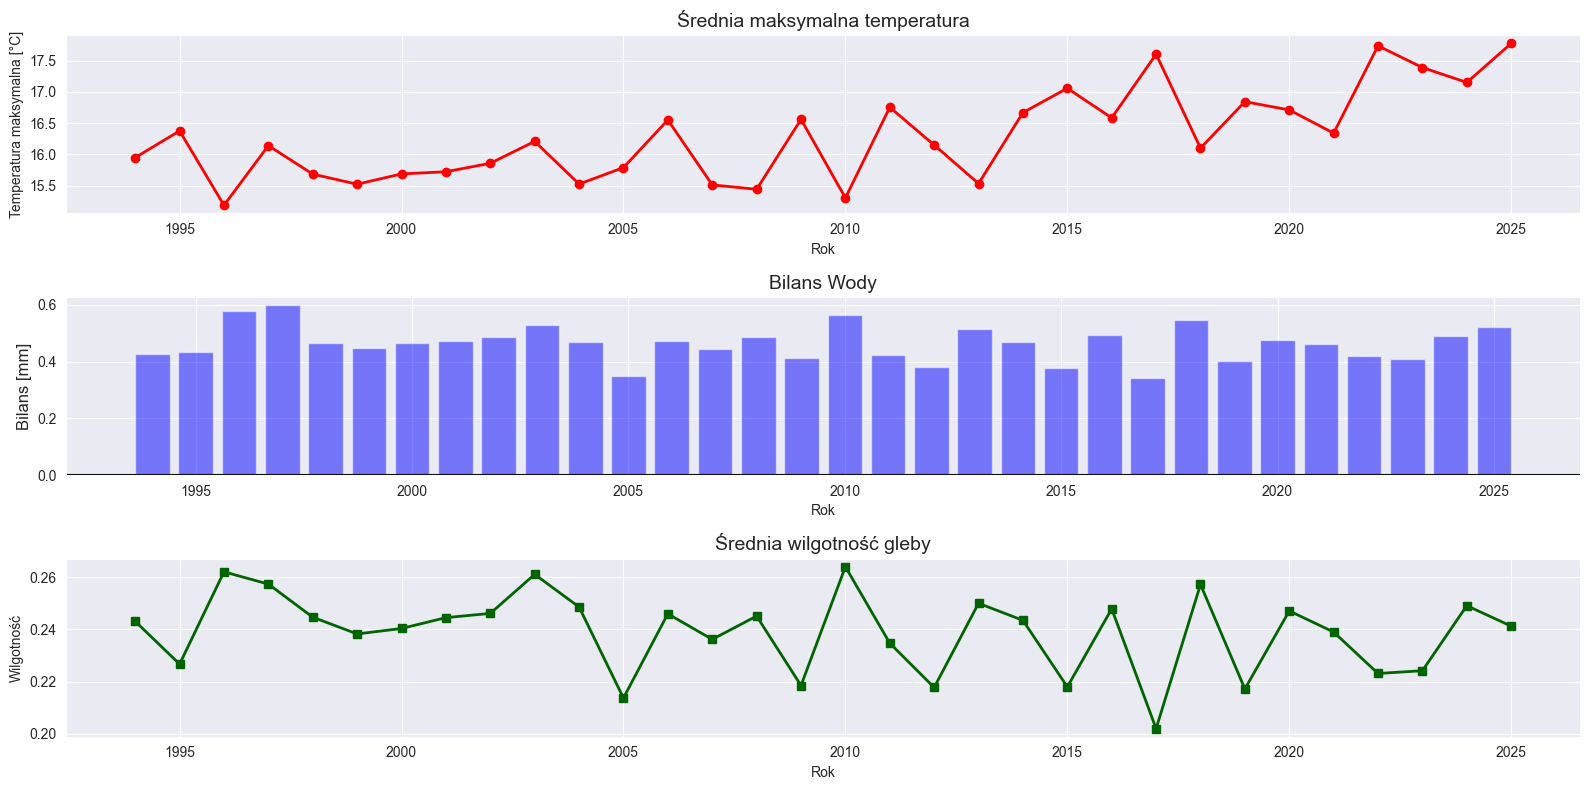

In [54]:
fig, axes = plt.subplots( 3, 1 , figsize = ( 16, 8 ))

#1
axes[0].plot(yearly_water['year'], yearly_water['t2m_max'], color ='red', marker='o',linewidth=2)
axes[0].set_title("Średnia maksymalna temperatura", fontsize = 14)
axes[0].set_ylabel("Temperatura maksymalna [°C]")
axes[0].set_xlabel("Rok")
colors = [ 'blue' if x > 0 else 'red' for x in yearly_water['P_minus_E']]
axes[1].bar( yearly_water['year'], yearly_water['P_minus_E'], color = colors, alpha = 0.5 )
axes[1].set_title("Bilans Wody", fontsize = 14)
axes[1].set_ylabel("Bilans [mm]", fontsize=12)
axes[1].set_xlabel("Rok")
axes[1].axhline(0, color='black', linewidth=1.5)
axes[1].grid(True)


axes[2].plot( yearly_water['year'], yearly_water['soil_moisture'], color = 'darkgreen', marker='s',linewidth=2)
axes[2].set_title("Średnia wilgotność gleby", fontsize = 14)
axes[2].set_ylabel("Wilgotność")
axes[2].set_xlabel("Rok")
axes[2].grid(True)
#2

#3

plt.tight_layout()
plt.show()

# Nasłonecznienie vs Zachmurzenie (ssrd_sum i tcc_mean)
tcc_mean	Średnie zachmurzenie nieba.
ssrd_sum	Suma promieniowania słonecznego docierającego do powierzchni.


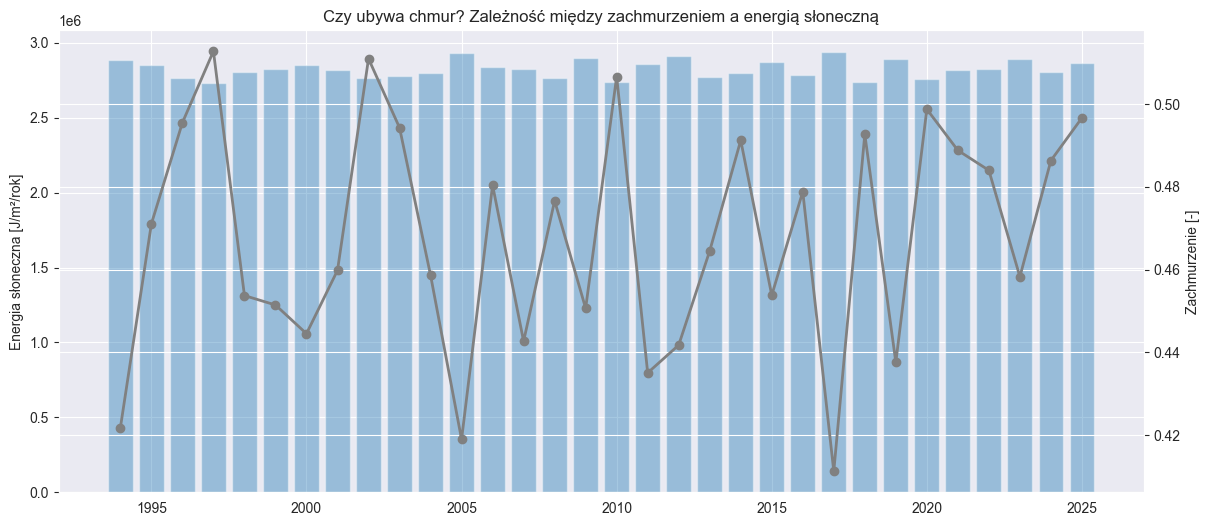

In [55]:
solar_cloud = (
    df
    .groupby('year')[['ssrd_sum', 'tcc_mean']]
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(14,6))

ax1.bar(
    solar_cloud['year'],
    solar_cloud['ssrd_sum'],
    alpha=0.4,
    label="Energia słoneczna"
)
ax1.set_ylabel("Energia słoneczna [J/m²/rok]")

ax2 = ax1.twinx()
ax2.plot(
    solar_cloud['year'],
    solar_cloud['tcc_mean'],
    color='gray',
    marker='o',
    linewidth=2,
    label='Zachmurzenie'
)
ax2.set_ylabel("Zachmurzenie [-]")

ax1.set_title("Czy ubywa chmur? Zależność między zachmurzeniem a energią słoneczną")

plt.show()


# Ofiary szuszy - wykres korelacji wilgotności gleby a gęstością roślinnościa

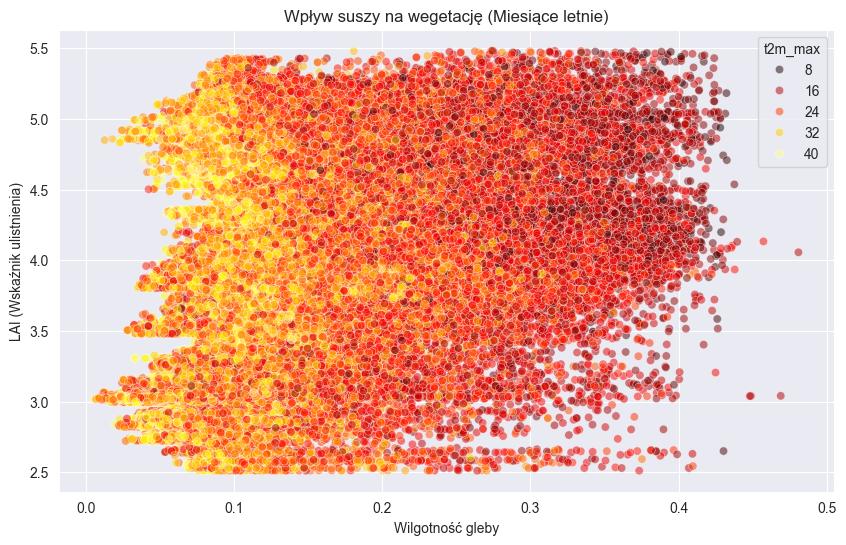

In [56]:
plt.figure(figsize=(10, 6))
# Wybieramy tylko miesiące letnie (np. czerwiec-sierpień), kiedy stres wodny jest największy
summer_df = df[df['month'].isin([6, 7, 8])]

sns.scatterplot(data=summer_df.sample(frac=0.1), x='soil_moisture', y='lai_total',
                hue='t2m_max', palette='hot', alpha=0.5)

plt.title("Wpływ suszy na wegetację (Miesiące letnie)")
plt.xlabel("Wilgotność gleby")
plt.ylabel("LAI (Wskaźnik ulistnienia)")
plt.show()

# Liczba dni z ekstremalną suszą glebową

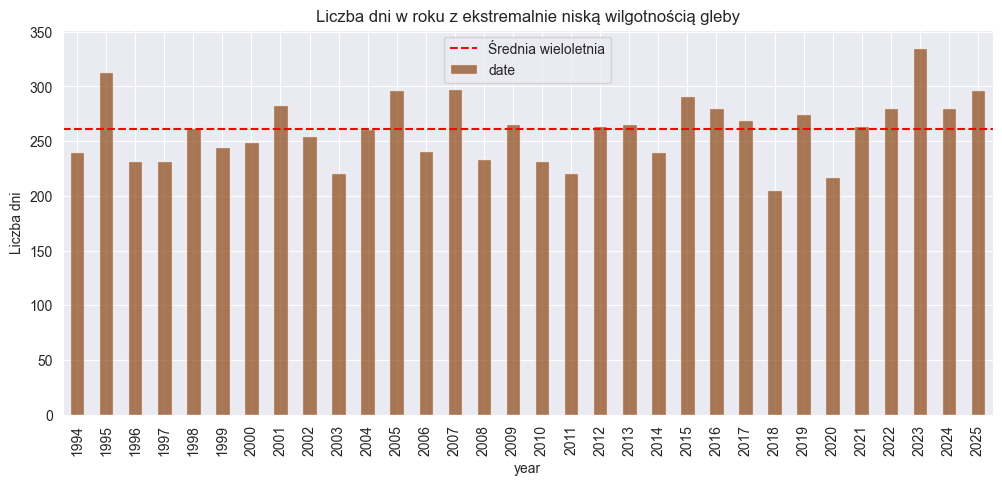

In [57]:
threshold = df['soil_moisture'].quantile(0.1)

dry_days = df[df['soil_moisture'] < threshold].groupby('year')['date'].nunique()

plt.figure(figsize=(12, 5))
dry_days.plot(kind='bar', color='saddlebrown', alpha=0.7)
plt.axhline(dry_days.mean(), color='red', linestyle='--', label='Średnia wieloletnia')
plt.title("Liczba dni w roku z ekstremalnie niską wilgotnością gleby")
plt.ylabel("Liczba dni")
plt.legend()
plt.show()

 # Dlaczego woda paruje szybciej?

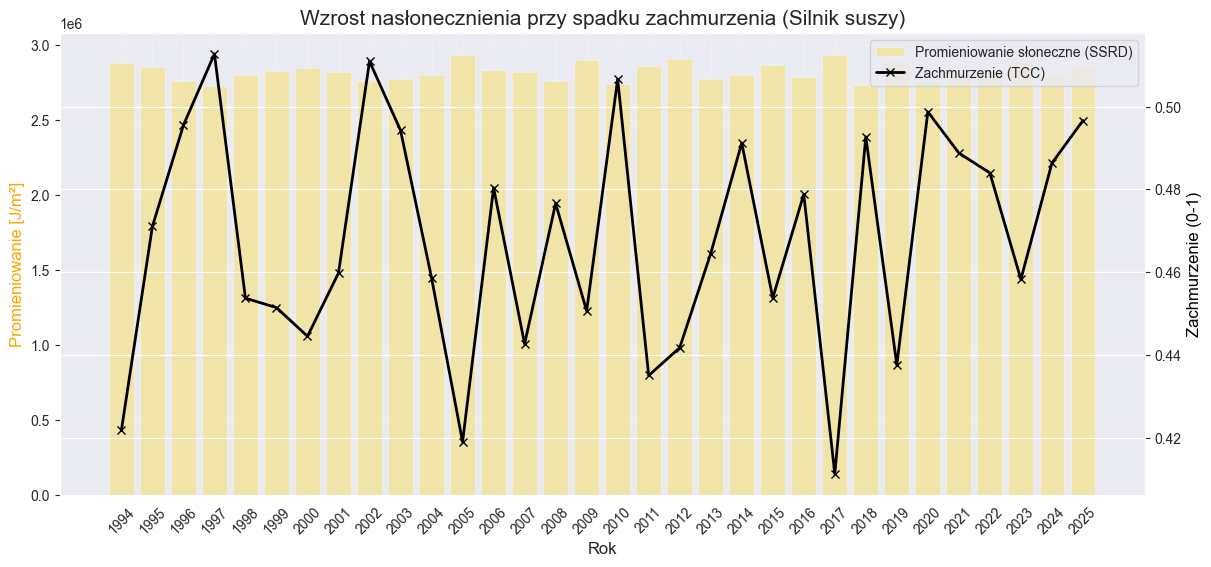

In [58]:
solar_cloud = df.groupby('year').agg({
    'ssrd_sum': 'mean',
    'tcc_mean': 'mean'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(solar_cloud['year'], solar_cloud['ssrd_sum'], color='gold', alpha=0.3, label='Promieniowanie słoneczne (SSRD)')
ax1.set_ylabel('Promieniowanie [J/m²]', color='orange', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(solar_cloud['year'], solar_cloud['tcc_mean'], color='black', marker='x', linewidth=2, label='Zachmurzenie (TCC)')
ax2.set_ylabel('Zachmurzenie (0-1)', color='black', fontsize=12)


plt.title('Wzrost nasłonecznienia przy spadku zachmurzenia (Silnik suszy)', fontsize=15)
ax1.set_xticks(solar_cloud['year'])
ax1.set_xticklabels(solar_cloud['year'], rotation=45)
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88))
ax1.grid(True, alpha=0.2)
ax1.set_xlabel("Rok", fontsize=12)
plt.show()

# Upał i Susza jednocześnie

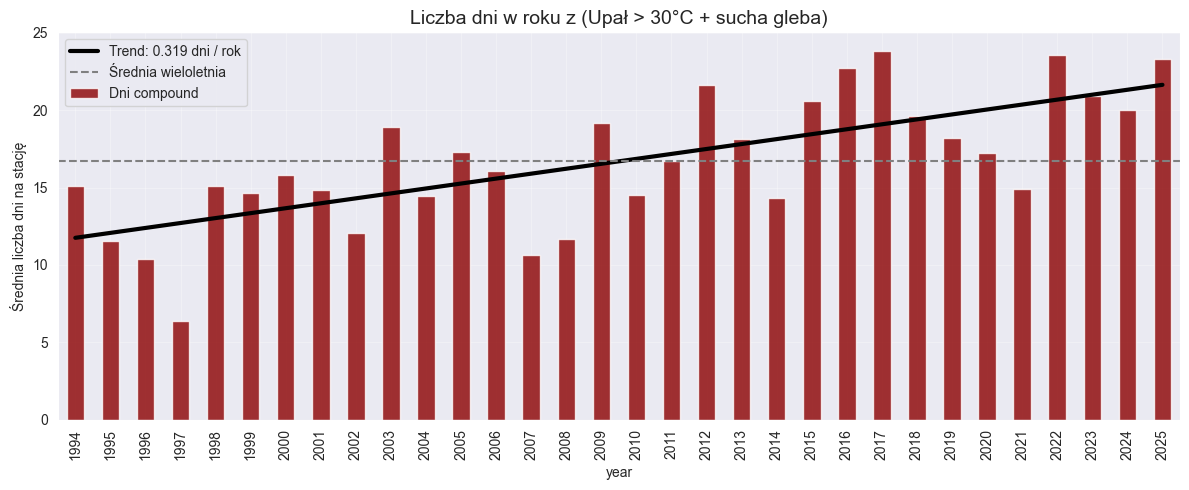

Trend dekadowy: 3.19 dni / 10 lat


In [13]:
sm_threshold = df['soil_moisture'].quantile(0.1)

df['compound_extreme'] = (
    (df['t2m_max'] > 30) &
    (df['soil_moisture'] < sm_threshold)
)

compound_days = df.groupby('year')['compound_extreme'].sum() / 400

years = compound_days.index.values
values = compound_days.values

z = np.polyfit(years, values, 1)
p = np.poly1d(z)

plt.figure(figsize=(12, 5))

compound_days.plot(
    kind='bar',
    color='darkred',
    alpha=0.8,
    label='Dni compound'
)

plt.plot(
    range(len(years)),
    p(years),
    color='black',
    linewidth=3,
    label=f"Trend: {z[0]:.3f} dni / rok"
)

plt.axhline(
    compound_days.mean(),
    color='gray',
    linestyle='--',
    label='Średnia wieloletnia'
)

plt.title("Liczba dni w roku z (Upał > 30°C + sucha gleba)", fontsize=14)
plt.ylabel("Średnia liczba dni na stację")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Trend dekadowy: {z[0]*10:.2f} dni / 10 lat")


# Kiedy zaczyna się wiosna

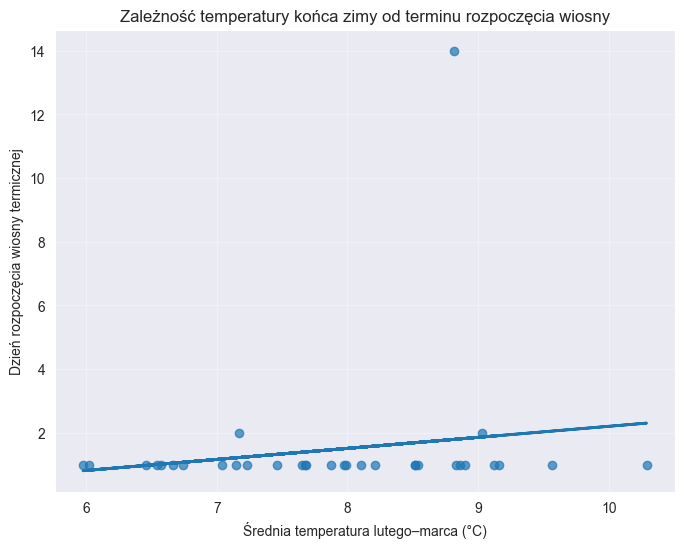

In [59]:
spring_start = (
    df[df['t2m_mean'] >= 8]
    .groupby('year')['dayofyear']
    .min()
)
spring_temp = (
    df[df['month'].isin([2, 3])]
    .groupby('year')['t2m_mean']
    .mean()
)
common_years = spring_temp.index.intersection(spring_start.index)

x = spring_temp.loc[common_years]
y = spring_start.loc[common_years]
plt.figure(figsize=(8, 6))

plt.scatter(x, y, alpha=0.7)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), linewidth=2)

plt.xlabel("Średnia temperatura lutego–marca (°C)")
plt.ylabel("Dzień rozpoczęcia wiosny termicznej")
plt.title("Zależność temperatury końca zimy od terminu rozpoczęcia wiosny")
plt.grid(alpha=0.3)

plt.show()


# Rozszerzające się Lato Sprawdzanie po temperaturze


Definicja pór termicznych (na podstawie średniej dobowej temperatury 2 m):
 - Zima: T < 8°C
 - Wiosna / Jesień: 8°C ≤ T < 20°C
 - Lato: T ≥ 20°C


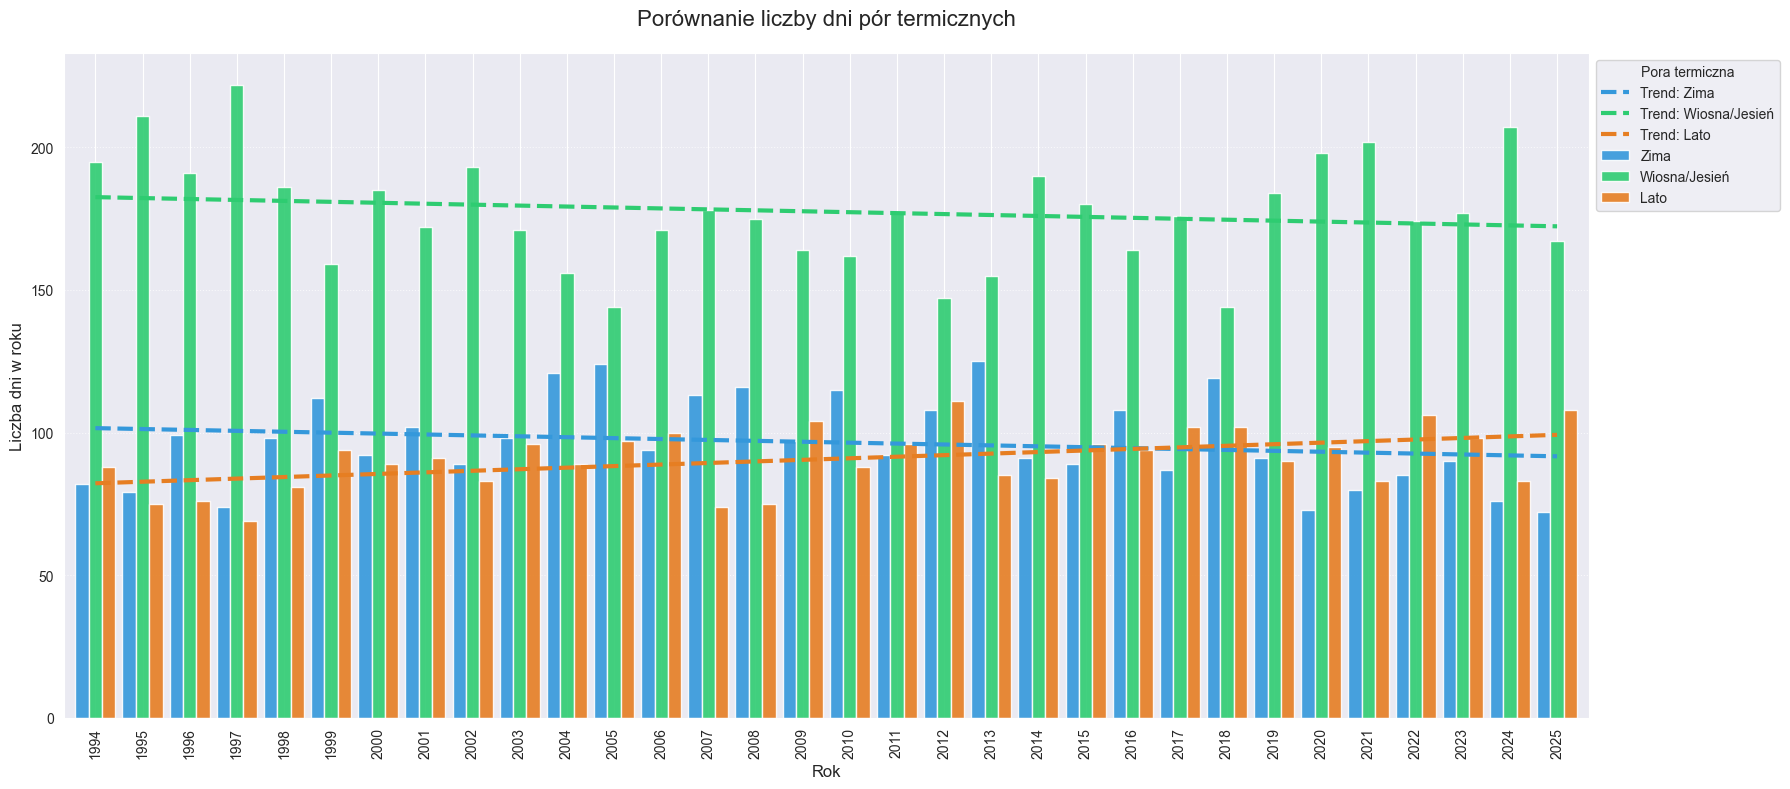

In [60]:
def get_thermal_season(temp):
    if temp < 8:
        return 'Zima'
    elif 8 <= temp < 20:
        return 'Wiosna/Jesień'
    else:
        return 'Lato'

daily_mean_region = (
    df.groupby(['year', 'date'])['t2m_mean']
    .mean()
    .reset_index()
)

daily_mean_region['thermal_season'] = (
    daily_mean_region['t2m_mean']
    .apply(get_thermal_season)
)

season_counts = (
    daily_mean_region
    .groupby(['year', 'thermal_season'])
    .size()
    .unstack(fill_value=0)
)

season_order = ['Zima', 'Wiosna/Jesień', 'Lato']
season_counts = season_counts.reindex(columns=season_order, fill_value=0)

fig, ax = plt.subplots(figsize=(18, 8))

season_counts.plot(
    kind='bar',
    ax=ax,
    width=0.85,
    stacked=False,
    color=['#3498db', '#2ecc71', '#e67e22'],
    alpha=0.9
)

ax.set_title("Porównanie liczby dni pór termicznych", fontsize=16, pad=20)
ax.set_xlabel("Rok", fontsize=12)
ax.set_ylabel("Liczba dni w roku", fontsize=12)

x = np.arange(len(season_counts))

trend_colors = {
    'Zima': '#3498db',
    'Wiosna/Jesień': '#2ecc71',
    'Lato': '#e67e22'
}

for season, color in trend_colors.items():
    y = season_counts[season].values

    coef = np.polyfit(x, y, 1)
    trend = np.poly1d(coef)

    ax.plot(
        x,
        trend(x),
        linestyle='--',
        linewidth=3,
        color=color,
        label=f"Trend: {season}"
    )


ax.grid(axis='y', linestyle=':', alpha=0.7)
ax.legend(title="Pora termiczna", loc='upper left', bbox_to_anchor=(1, 1))


print("\nDefinicja pór termicznych (na podstawie średniej dobowej temperatury 2 m):")
print(" - Zima: T < 8°C")
print(" - Wiosna / Jesień: 8°C ≤ T < 20°C")
print(" - Lato: T ≥ 20°C")

plt.tight_layout()
plt.show()


# Kiedy zaczyna się Wiosna?

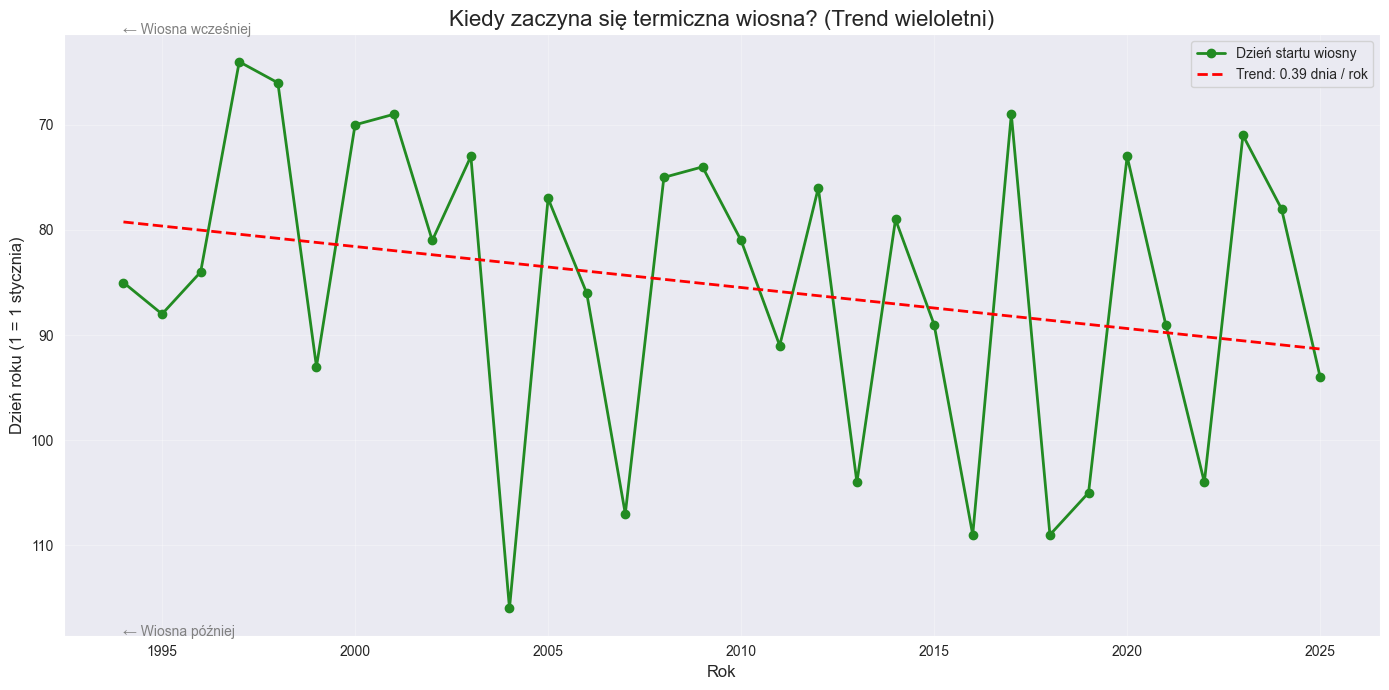

Trend: Wiosna zaczyna się o 3.9 dni wcześniej na każdą dekadę.
W ciągu całego badanego okresu wiosna przesunęła się o ok. 12.1 dni.


In [61]:
daily_mean_region['date'] = pd.to_datetime(daily_mean_region['date'])

daily_mean_region['temp_roll'] = daily_mean_region.groupby('year')['t2m_mean'].transform(lambda x: x.rolling(5).mean())

def find_spring_start(group):
    group_filtered = group[group['date'].dt.dayofyear > 46]

    spring_days = group_filtered[group_filtered['temp_roll'] > 12]

    if not spring_days.empty:
        return spring_days['date'].iloc[0].dayofyear
    return None

spring_starts = daily_mean_region.groupby('year').apply(find_spring_start, include_groups=False).dropna()

spring_starts = spring_starts.dropna()

plt.figure(figsize=(14, 7))
plt.plot(spring_starts.index, spring_starts.values, marker='o', color='forestgreen', linewidth=2, label='Dzień startu wiosny')

z = np.polyfit(spring_starts.index, spring_starts.values.astype(float), 1)
p = np.poly1d(z)
plt.plot(spring_starts.index, p(spring_starts.index), "r--", linewidth=2, label=f"Trend: {z[0]:.2f} dnia / rok")

plt.title("Kiedy zaczyna się termiczna wiosna? (Trend wieloletni)", fontsize=16)
plt.ylabel("Dzień roku (1 = 1 stycznia)", fontsize=12)
plt.xlabel("Rok", fontsize=12)

plt.gca().invert_yaxis()

plt.text(spring_starts.index[0], plt.ylim()[0], "← Wiosna później", color='gray', fontsize=10)
plt.text(spring_starts.index[0], plt.ylim()[1], "← Wiosna wcześniej", color='gray', fontsize=10)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

days_earlier = abs(z[0] * (spring_starts.index[-1] - spring_starts.index[0]))
print(f"Trend: Wiosna zaczyna się o {abs(z[0]*10):.1f} dni wcześniej na każdą dekadę.")
print(f"W ciągu całego badanego okresu wiosna przesunęła się o ok. {days_earlier:.1f} dni.")

- Ekstremalność zamiast stabilności: Zimy stają się łagodniejsze, ale marzec/kwiecień bywają bardziej niestabilne. Może być tak, że dawniej temperatura rosła powoli i stabilnie (szybko przekraczając 12°C), a teraz mamy serie nagłych przymrozków w marcu, które "resetują" Twój licznik 5-dniowej średniej.
- Zmiana cyrkulacji: Nad Hiszpanią częściej zatrzymują się układy wysokiego ciśnienia, które zimą dają słońce, ale w marcu mogą ściągać chłodne masy powietrza z północy, opóźniając ten stały wzrost temperatury powyżej 12°C.
- Definicja "Wiosny": Pamiętaj, że badamy tu tylko temperaturę powietrza. Może być tak, że Twoje wcześniejsze wykresy LAI (roślinności) pokazują, że rośliny startują wcześniej (bo reagują na słońce, którego masz więcej – co pokazałeś na wykresie SSRD), mimo że samo powietrze (t2m) nagrzewa się wolniej.

# Mapa Hiszpani

In [3]:
import plotly.express as px

uniqie_coords = df[['latitude','longitude']].drop_duplicates()

fig = px.scatter_mapbox(
    uniqie_coords,
    lat='latitude',
    lon='longitude',
    zoom=5,
    height=600
)

fig.update_layout( mapbox_style="open-street-map" )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

C:\Users\oliwi\AppData\Local\Temp\ipykernel_13988\3793096750.py:5: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(
